In [1]:
%matplotlib inline
import ipyvolume as ipv

import numpy as np
import os
import cv2
import yaml
import sys
import json
from glob import glob
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
from scipy.io import wavfile as wv
from scipy.signal import spectrogram
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d, RectBivariateSpline

#from scipy.interpolate import griddata
import scipy.optimize as opt

# import pims
# import trackpy as tp

from cameras import CameraSystem

In [2]:
view_to_sly_map = {3:0,2:1,7:2,6:3,0:4,1:5,4:6,5:7}
sly_to_view_map = {v:k for k, v in view_to_sly_map.items()}

In [3]:
def get_json(file):
    with open(file) as json_file:
        return json.load(json_file)

def get_rostime(filename):
    return float(filename[-31:-11])

def get_view_num(filename):
    sly = int(filename[-10:-9])
    view = sly_to_view_map[sly]
    return view

def get_set_num(filename):
    set_num = filename.split('/')[-3][-5:]
    return set_num

def get_object_data(object_entry, filename):
    object_class = object_entry['classTitle']
    try:
        ID_tag = [t for t in object_entry['tags'] if t['name'] == 'ID'][0]
        object_id = ID_tag['value']
        object_tag = f"{object_class}-{object_id}"
    except:
        rostime = get_rostime(filename)
        view_num = get_view_num(filename)
        set_num = get_set_num(filename)
        object_id = None
        object_tag = f"{object_class}-None"
        print(f"{set_num}, view{view_to_sly_map[view_num]}, {rostime}, {object_tag}")
    
    singing_tag = [t for t in object_entry['tags'] if t['name'] == 'singing']
    if len(singing_tag) == 1:
        singing = 1
    else:
        singing = 0
    
    xy = object_entry['points']['exterior'][0]
    
    data = [object_class, object_id, object_tag, singing] + xy
    
    return data

In [4]:
cam_sys = CameraSystem(device='cuda')

In [5]:
data_dir = '/data/aviary/sound_localization'
annot_dir = os.path.join(data_dir, 'sound_localization_dataset')
sound_file_dir = os.path.join(data_dir, 'sound_slices')

In [6]:
meta = get_json(os.path.join(annot_dir, "meta.json"))

In [7]:
class_id_to_name = {d['id']:d['title'] for d in meta['classes']}

In [8]:
tag_id_to_name = {d['id']:d['name'] for d in meta['tags']}

In [9]:
# Collect a list of all annotation filenames
filenames = glob(os.path.join(annot_dir,'*/ann/*.json'))

In [10]:
objects = []

for filename in filenames:
    rostime = get_rostime(filename)
    view_num = get_view_num(filename)
    set_num = get_set_num(filename)
    json_data = get_json(filename)

    for object_entry in json_data['objects']:
        object_data = get_object_data(object_entry, filename)
        object_data = [rostime, view_num, set_num] + object_data
        objects.append(object_data)

set34, view3, 1553516303.248163, bird_head-None
set09, view3, 1553430577.7916074, bird_head-None
set06, view1, 1553430393.0349905, bird_head-None
set85, view1, 1553518554.6019871, bird_head-None
set81, view3, 1553518213.0862958, bird_head-None
set17, view2, 1553431231.7775471, bird_head-None
set17, view2, 1553431231.7775471, bird_head-None
set17, view0, 1553431231.7775471, bird_head-None
set00, view4, 1553429829.539593, bird_head-None
set01, view1, 1553429851.6623323, bird_head-None
set01, view5, 1553429864.186125, bird_head-None
set80, view6, 1553518151.742164, bird_head-None
set80, view2, 1553518118.744169, bird_head-None
set11, view2, 1553430735.9507432, bird_head-None
set12, view7, 1553430820.4931974, bird_head-None
set12, view1, 1553430755.0746102, bird_head-None
set12, view7, 1553430779.7473776, bird_head-None
set05, view1, 1553430156.057818, bird_head-None
set13, view2, 1553430942.1053638, bird_head-None
set13, view7, 1553430860.1632662, bird_head-None
set13, view1, 1553430942.1

In [11]:
print(" ,".join(["rostime","view_num","set_num","object_class","object_id","object_tag","singing","x","y"]))
print(objects[1])

rostime ,view_num ,set_num ,object_class ,object_id ,object_tag ,singing ,x ,y
[1553516290.3491416, 7, 'set34', 'bird_head', 2, 'bird_head-2', 0, 1360, 350]


In [12]:
OJBECT_ID_IDX = 4
objects = [o for o in objects if o[OJBECT_ID_IDX] is not None]

In [13]:
data = np.array(objects, dtype=object)

In [14]:
ROSTIME_IDX = 0
SET_IDX = 2
ID_TAG_IDX = 5
SINGING_IDX = 6
rostimes = np.unique(data[:,ROSTIME_IDX])
id_tags = np.unique(data[:,ID_TAG_IDX])

In [15]:
to_triangulate = []
for rostime in rostimes:
    for id_tag in id_tags:
        matches = data[(data[:,ROSTIME_IDX] == rostime) & (data[:,ID_TAG_IDX] == id_tag), :]
        to_triangulate.append(matches)

to_triangulate = [t for t in to_triangulate if t.shape[0] > 0]

In [16]:
points = np.zeros((cam_sys.num_cams, len(to_triangulate), 3))
point_info = np.zeros((len(to_triangulate), 4), dtype = object)
for idx, matches in enumerate(to_triangulate):
    point_info[idx] = matches[0][[ROSTIME_IDX, SET_IDX, ID_TAG_IDX, SINGING_IDX]]
    for match in matches:
        view_num = match[1]
        entry = np.append(match[-2:], 1)
        points[view_num, idx] = entry

In [17]:
points_by_rostime = {}
for pi in point_info:
    if 'bill_tip' in pi[2]:
        continue
    if pi[0] not in points_by_rostime:
        points_by_rostime[pi[0]] = {'set':pi[1], 'ids':[int(pi[2].split('-')[-1])]}
    else:
        points_by_rostime[pi[0]]['ids'].append(int(pi[2].split('-')[-1]))

In [18]:
for k, v in points_by_rostime.items():
    if len(v['ids']) != 15 or sorted(v['ids']) != list(range(1,16)):
        missing = list(set(range(1,16)) - set(v['ids']))
        if missing:
            missing = " ".join([str(m) for m in missing])
        else:
            missing = ""
        extra = list(set(v['ids']) - set(range(1,16)))
        if extra:
            extra = " ".join([str(e) for e in extra])
        else:
            extra = ""
        print(f"{v['set']}, {k},  {missing}, {extra}")

set01, 1553429848.912985,  15, 
set03, 1553430069.0914724,  12, 
set10, 1553430655.784263,  15, 
set10, 1553430693.8803608,  15, 
set11, 1553430725.1526363,  14 15, 
set11, 1553430735.9507432,  14 15, 
set12, 1553430820.4931974,  15, 
set12, 1553430838.8663094,  15, 
set13, 1553430847.8656468,  15, 
set13, 1553430860.1632662,  15, 
set13, 1553430942.1053638,  12 13 14 15, 
set15, 1553431077.3430102,  15, 
set16, 1553431183.1076186,  , 109
set18, 1553431357.9651446,  15, 
set19, 1553431500.351818,  2 3 4 5 6 7 8 9 10 11 12 13 14 15, 
set39, 1553516614.3915627,  , 16 17
set39, 1553516625.640254,  , 16 17
set40, 1553516634.764417,  , 16 17
set40, 1553516645.5134385,  , 16 17
set40, 1553516654.4374478,  , 16 17
set41, 1553516715.6061876,  2 3 4 5 6 7 8 9 10 11 12 13 14 15, 
set49, 1553517067.1469178,  15, 
set63, 1553517511.1283453,  2 3 4 5 6 7 8 9 10 11 12 13 14 15, 
set63, 1553517522.002053,  2 3 4 5 6 7 8 9 10 11 12 13 14 15, 
set63, 1553517523.7771602,  2 3 4 5 6 7 8 9 10 11 12 13 14 

In [19]:
points_3d, err = cam_sys.triangulate_points(points, iters=1000)
points_3d = points_3d.cpu().numpy()
err = err.cpu().numpy()

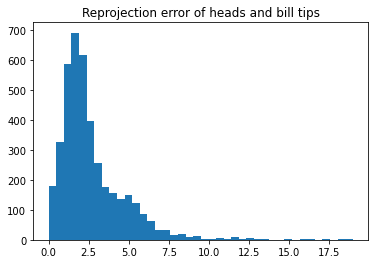

In [20]:
plt.hist(err[err<20], bins=40)
plt.title("Reprojection error of heads and bill tips")
plt.show()

In [21]:
print(f"{sum(err<10)} good points, {sum(err>10)} bad points")

4065 good points, 97 bad points


In [22]:
for pi in point_info[(err>20) & (err<50)]:
    rostime = pi[0]
    set_num = pi[1]
    object_tag = pi[2]
    singing = "singing" if pi[3] == 1 else ""
    print(f"{set_num}, {rostime}, {object_tag}, {singing}")

set10, 1553430693.8803608, bird_head-6, 
set11, 1553430703.7794447, bird_head-13, 
set11, 1553430728.451595, bird_head-5, 
set11, 1553430728.451595, bird_head-6, 
set15, 1553431077.3430102, bird_head-2, 
set15, 1553431077.3430102, bird_head-3, 
set15, 1553431077.3430102, bird_head-4, 
set15, 1553431077.3430102, bird_head-5, 
set15, 1553431100.7154834, bird_head-2, 
set17, 1553431231.7775471, bird_head-2, 
set17, 1553431319.9442196, bird_head-5, 
set18, 1553431363.215169, bird_head-10, 
set18, 1553431363.215169, bird_head-9, 
set44, 1553516864.5161, bird_head-3, 
set44, 1553516864.5161, bird_head-4, 
set44, 1553516884.0396612, bird_head-8, 
set44, 1553516884.0396612, bird_head-9, 
set50, 1553517104.4677758, bird_head-10, 
set56, 1553517357.767711, bird_head-10, 
set56, 1553517359.1428251, bird_head-4, 
set83, 1553518288.0790832, bird_head-12, 


In [23]:
for pi, e in zip(point_info[(-err).argsort()], err[(-err).argsort()]):
    try:
        rostime = pi[0]
        set_num = pi[1]
        object_tag = pi[2]
        singing = "singing" if pi[3] == 1 else ""
        print(f"{set_num}, {rostime}, {object_tag}, {singing}, {e:0.2f}")
    except:
        continue

set79, 1553518100.9712474, bird_head-14, , 10000.00
set56, 1553517357.767711, bird_head-5, , 309.71
set32, 1553516215.5064404, bird_head-15, , 264.24
set33, 1553516277.0003934, bird_head-9, , 263.17
set17, 1553431319.9442196, bird_head-4, , 243.68
set33, 1553516285.0996726, bird_head-12, , 219.97
set18, 1553431357.9651446, bird_head-12, , 205.80
set50, 1553517144.6643782, bird_head-14, , 172.06
set17, 1553431262.5995975, bird_head-8, , 150.88
set34, 1553516303.248163, bird_head-7, , 134.59
set17, 1553431262.5995975, bird_head-9, , 113.22
set17, 1553431262.5995975, bird_head-2, , 102.64
set34, 1553516297.9983933, bird_head-4, , 101.77
set16, 1553431183.1076186, bird_head-13, , 101.28
set50, 1553517124.415981, bird_head-5, , 100.12
set50, 1553517124.415981, bird_head-4, , 93.01
set33, 1553516277.0003934, bird_head-2, , 89.51
set17, 1553431231.7775471, bird_head-3, , 78.62
set49, 1553517067.1469178, bird_head-5, , 77.49
set11, 1553430728.451595, bird_head-7, , 65.75
set56, 1553517357.7677

set18, 1553431349.441129, bird_head-8, , 1.19
set38, 1553516530.5245385, bird_head-10, , 1.18
set27, 1553432122.5156603, bird_head-6, , 1.18
set44, 1553516890.9134421, bird_head-3, , 1.18
set05, 1553430323.5657437, bird_head-4, , 1.18
set11, 1553430728.451595, bill_tip-1, singing, 1.18
set56, 1553517359.1428251, bird_head-11, , 1.18
set86, 1553518697.0379782, bird_head-2, , 1.18
set05, 1553430323.5657437, bird_head-12, , 1.18
set34, 1553516290.3491416, bird_head-14, , 1.17
set31, 1553432388.9640245, bird_head-4, , 1.17
set54, 1553517306.5979784, bird_head-14, , 1.17
set81, 1553518154.1918557, bird_head-1, , 1.17
set83, 1553518256.056968, bird_head-10, , 1.17
set54, 1553517300.5488148, bird_head-7, , 1.17
set59, 1553517410.463086, bird_head-15, , 1.17
set08, 1553430526.4218924, bill_tip-1, singing, 1.17
set08, 1553430571.0421348, bird_head-13, , 1.17
set28, 1553432171.7108335, bird_head-8, , 1.17
set22, 1553431770.9753525, bird_head-15, , 1.17
set27, 1553432110.2170846, bird_head-8, , 1

In [24]:
good = err < 10
good_points_3d = points_3d[good]
good_points_info = point_info[good]

In [25]:
singing = good_points_info[:,3] == 1
singing_points_3d = good_points_3d[singing]
nonsinging_points_3d = good_points_3d[singing == 0]
singing_points_info = good_points_info[singing]
nonsinging_points_info = good_points_info[singing == 0]

In [26]:
# Now we select only the cases that have bill tips
# we will find the corresponding head-ID tag and combine them

In [27]:
bill_tip_info = np.array([l for l in singing_points_info if 'bill_tip' in l[2]])

In [28]:
# head_to_tip will be {rostime:{'ids':[], 'base_tips': [base, tip]}}
# 'base_tips' is an nx2x3 array corresponding to the base and tips
# of the ids
singing_locations = {}
for info in bill_tip_info:
    rostime = info[0]
    idd = int(info[2].split('-')[-1])
    bill_tip_tag = info[2]
    
    
    try:
        point_names = ["bill_tip","bird_head"]
        point_locs = np.zeros((len(point_names),3))
        for point_name_idx, point_name in enumerate(point_names):
            point_tag = bill_tip_tag.replace("bill_tip",point_name)

            singing_idx = (singing_points_info[:,0] == rostime) & (singing_points_info[:,2] == point_tag)
            point_locs[point_name_idx] = singing_points_3d[singing_idx]

        if rostime not in singing_locations:
            singing_locations[rostime] = {'ids':[], 'base_tips':[]}

        singing_locations[rostime]['ids'].append(idd)
        singing_locations[rostime]['base_tips'].append(point_locs)
    
    except Exception as e:
        print("Something went wrong!")
        print(info)
        print(e)

for sl in singing_locations:
    singing_locations[sl]['base_tips'] = np.array(singing_locations[sl]['base_tips'])

Something went wrong!
[1553430847.8656468 'set13' 'bill_tip-2' 1]
could not broadcast input array from shape (0,3) into shape (3,)


In [29]:
print(f"We have {len(singing_locations)} male song examples in the dataset")

We have 172 male song examples in the dataset


In [30]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    
    source: https://stackoverflow.com/questions/45142959/calculate-rotation-matrix-to-align-two-vectors-in-3d-space
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    if any(v): #if not all zeros then 
        c = np.dot(a, b)
        s = np.linalg.norm(v)
        kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
        return np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))

    else:
        return np.eye(3) #cross of all zeros only occurs on identical directions  
    

def aviary_to_head_frame(point, base_tip, proj_z = True):
    """Rotate 3D point to the head coordinate frame
    
    The head coordinate frame is defined by:
        +y pointing along the vector from the head to the bill tip
        +z aligned with aviary_z
        and the head located at the origin.
    
    Args:
        point: a 3D point in the aviary coordinate frame
        base_tip: a 2x3 array representing the 3D coordinates
            of the head and bill tip in the aviary coordinate frame
        proj_z: if true, drop the z coordinates of the points
                      
    Returns:
        t_head_to_p_in_head: the 2D or 3D cordinates of the point in the head frame
    """
    t_head_to_p_in_aviary = point-base_tip[0]
    t_head_to_tip_in_aviary = base_tip[1] - base_tip[0]
    plus_y_in_head = np.array([0,1,0])
    starting_vector = np.array([t_head_to_tip_in_aviary[0], t_head_to_tip_in_aviary[1], 0])
    
    if proj_z:
        t_head_to_p_in_aviary[2] = 0
        t_head_to_tip_in_aviary[2] = 0
        
    # we want to rotate such that t_head_to_tip_in_aviary is
    # rotated to +y in head
    # from https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d
    R_from_aviary_to_head = rotation_matrix_from_vectors(starting_vector, plus_y_in_head)
    
    t_head_to_p_in_head = R_from_aviary_to_head @ t_head_to_p_in_aviary

    if proj_z:
        t_head_to_p_in_head = t_head_to_p_in_head[:2]
        
    return t_head_to_p_in_head

In [31]:
# Now we localize the sounds

In [1]:
from SoundLoc.SoundLoc2 import SoundLocalizer

In [33]:
sound_files = sorted(glob(os.path.join(sound_file_dir, "*.wav")))
sound_rostimes = np.array([[sf.split("_")[-3].split("-")[0], 
                            sf.split("_")[-3].split("-")[1]] for sf in sound_files], dtype=np.float64)

In [34]:
def find_match(rostime, sound_files, sound_rostimes):
    mask = (sound_rostimes[:,0] < rostime) & (sound_rostimes[:,1] > rostime)
    result = np.array(sound_files)[mask == 1]
    if len(result) == 1:  
        return result[0]
    else:
        return ""

In [35]:
singing_rostimes = list(singing_locations.keys())
singing_filenames = [find_match(sr, sound_files, sound_rostimes) for sr in singing_rostimes]

In [36]:
def make_spec(wavpart, fs, **kwargs):
    """Wrapper for scipy spectrogram that flips and clips"""
    f, ts, Sxx = spectrogram(wavpart, fs, **kwargs)
    Sxx = np.flipud(Sxx)
    Sxx = np.log(Sxx)
    Sxx = np.clip(Sxx, -2, 3)
    
    return Sxx

In [37]:
sn=256
fact=2

window_size = 256*fact
skip=sn/fact
spectrograms = []
for sf in singing_filenames:
    fs, this_wav = wv.read(sf)
    this_wav = np.transpose(this_wav)
    avg_wav = np.mean(this_wav, axis = 0)
    spec = make_spec(avg_wav, fs, window="hann", nperseg=window_size, noverlap = window_size-skip)[:126*fact,:]
    spectrograms.append(spec)

In [38]:
def pad_spec(spec, spec_pad_len):
    """Crops a spec or pads it on the end so that it is spec_pad_len long"""
    
    length = spec.shape[1]
    
    if length >= spec_pad_len:
        new_spec = spec[:,0:spec_pad_len]
    
    else:
        # pad with the 1th percentile of pixel values
        # tried using the values along each row from each sample, but worried it would affect the embedding
        # # minval = np.percentile(spec, 1, axis = 1)[:,None]
        # better just to use an overall small value
        minval = np.percentile(spec, 1)
        pad = minval*np.ones((spec.shape[0], spec_pad_len - length))
        new_spec = np.hstack((spec, pad))
        
    return new_spec

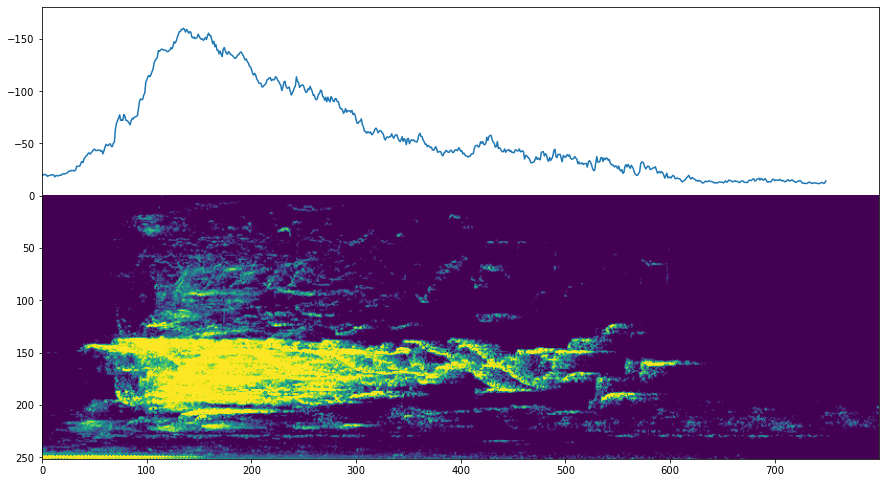

In [39]:
fig, axs = plt.subplots(1,1, figsize = (15,10))
mean_spec = np.max(np.array([pad_spec(a, 800) for a in spectrograms]), axis = 0)
axs.imshow(mean_spec)
mean_spec = np.sum(np.max(np.array([pad_spec(a, 750) for a in spectrograms]), axis = 0), axis = 0)
axs.plot((-mean_spec-550)/4)
plt.show()

In [40]:
sn=256
fact=2
fs = 48000

window_size = 256*fact
skip=sn/fact

print(f"We will limit our song window to {400*skip/fs} seconds")
window_len = 400*skip/fs

We will limit our song window to 1.0666666666666667 seconds


In [41]:
data_name = 'srp_outputs.npy'
if os.path.exists(os.path.join(data_dir, data_name)):
    temp = np.load(os.path.join(data_dir, data_name), allow_pickle=True)[()]
    all_outputs = [temp[sf] for sf in singing_filenames]
else:
    all_outputs = {}
    for sf in tqdm(singing_filenames):
        sl = SoundLocalizer(sf)
        output = sl.wav_to_srp(sl.start_time+0.001, min(sl.start_time + window_len, sl.end_time-0.001))
        all_outputs[sf] = output
    np.save(os.path.join(data_dir, data_name), all_outputs)
    all_outputs = [all_outputs[sf] for sf in singing_filenames]

In [42]:
dist_to_sound_stats = {}

In [43]:
def update_max_points(all_outputs, mode='none', sigma=0):
    '''Recalculate location of maximum SRP
    
    Args:
        mode (str): can be none, smooth, or subpixel
        sigma (int): amount of gaussian smoothing
    
    '''
    for out_idx, out in enumerate(all_outputs):
        temp_srp = out['srp']

        if mode == 'none':
            out['max_pt_updated'] = out['max_pt']
            continue

        if sigma > 0:
            temp_srp = gaussian_filter(temp_srp, sigma = sigma)

        max_loc = np.unravel_index(np.argmax(temp_srp), temp_srp.shape)

        xyz_grid = out['gridpts'].copy().reshape(out['srp'].shape[0], out['srp'].shape[1], out['srp'].shape[2], -1)

        if mode == 'smooth':
            out['max_pt_updated'] = xyz_grid[max_loc][None,:]
            continue

        maxx = xyz_grid.shape[0]
        xp = xyz_grid[max(0,max_loc[0]-5):min(max_loc[0]+5, maxx), max_loc[1], max_loc[2]][:,0]
    #     fp = temp_srp[max(0,max_loc[0]-5):min(max_loc[0]+5, maxx), max_loc[1], max_loc[2]]
        xs = np.linspace(-0.1,0.1,200) + xyz_grid[max_loc[0], max_loc[1], max_loc[2]][0]
        xs = xs[(xs >= np.min(xp)) & (xs <= np.max(xp))]

    #     f = interp1d(xp, fp, kind='cubic')
    #     ipx = f(xs)
    #     ipx_max = np.argmax(ipx)

        maxy = xyz_grid.shape[1]
        
#         print(max_loc[0], max(0,max_loc[1]-5), min(max_loc[1]+5, maxy), max_loc[2])
#         print(xyz_grid[max_loc[0], 0:maxy, max_loc[2]])
        
        yp = xyz_grid[max_loc[0], max(0,max_loc[1]-5):min(max_loc[1]+5, maxy), max_loc[2]][:,1]
        fp = temp_srp[max_loc[0], max(0,max_loc[1]-5):min(max_loc[1]+5, maxy), max_loc[2]]
        ys = np.linspace(-0.1,0.1,200) + xyz_grid[max_loc[0], max_loc[1], max_loc[2]][1]
        ys = ys[(ys >= np.min(yp)) & (ys <= np.max(yp))]

    #     f = interp1d(yp, fp, kind='cubic')
    #     ipy = f(ys)
    #     ipy_max = np.argmax(ipy)

        fp = temp_srp[max(0,max_loc[0]-5):min(max_loc[0]+5, maxx), max(0,max_loc[1]-5):min(max_loc[1]+5, maxy), max_loc[2]]
        xy = np.array(np.meshgrid(xs, ys)).T
        xy_flat = xy.reshape(-1,2)
        
#         print(xp)
#         print(yp)
        
        f = RectBivariateSpline(xp, yp, fp, s = 0)
        fev = f.ev(xy_flat[:,0], xy_flat[:,1])
        fev_max = np.argmax(fev)
        themax_idx = np.unravel_index(fev_max, xy.shape[:2])
        themax = xy_flat[fev_max,:]

        out['max_pt_updated'] = np.array([[themax[0], themax[1], xyz_grid[max_loc[0], max_loc[1], max_loc[2]][2]]])
    
    return all_outputs

def calc_dist_to_sound(all_outputs, singing_rostimes, singing_locations, lab_offset=[0, 0]):
    for out, rt in zip(all_outputs, singing_rostimes):
        singing_locations[rt]['max_pt'] = out['max_pt_updated']
    
    srp_max = [out['max_pt_updated'] for out, rt in zip(all_outputs, singing_rostimes)]
    norms = []
    for _, sl in singing_locations.items():
        base_tip = sl['base_tips'][0]
        base_tip_norm = np.sqrt(np.sum((base_tip[0]-base_tip[1])**2))
        norms.append(base_tip_norm)
    norms = np.array(norms)
    
    bill_tips = []
    bill_tips_lab = []
    sound_locs = []
    sound_locs_lab = []
    for _, sl in singing_locations.items():
        point = sl['max_pt'][0]
        #point[0] = point[0] + lab_offset[0]
        #point[1] = point[1] + lab_offset[1]
        base_tip = sl['base_tips'][0]
        base_tip_norm = np.sqrt(np.sum((base_tip[0]-base_tip[1])**2))
        bill_tips_lab.append(base_tip[1] - base_tip[0])
        sound_locs_lab.append(point - base_tip[0])
        if base_tip_norm > 0.07:
            continue

        point_head = aviary_to_head_frame(point, base_tip)
        base_head = aviary_to_head_frame(base_tip[0], base_tip)
        tip_head = aviary_to_head_frame(base_tip[1], base_tip)
        bill_tips.append(tip_head)
        sound_locs.append(point_head)

    dist_to_sound = np.sqrt(np.sum(np.array(sound_locs)**2, axis = 1))
    
    return all_outputs, singing_locations, dist_to_sound

In [44]:
dist_to_sound_stats = {}

In [45]:
mode = 'none'
sigma = 0
all_outputs = update_max_points(all_outputs, mode=mode, sigma=sigma)
all_outputs, singing_locations, dist_to_sound = calc_dist_to_sound(all_outputs, singing_rostimes, singing_locations)
dist_to_sound_stats[f"{sigma}-{mode}"] = f"sigma: {sigma}, {np.mean(dist_to_sound[dist_to_sound<0.2])} pm {np.std(dist_to_sound[dist_to_sound<0.2])}"

In [46]:
for mode in ['smooth','subpixel']:
    for sigma in tqdm([0,1,2,3,4]):
        try:
            all_outputs = update_max_points(all_outputs, mode=mode, sigma=sigma)
            all_outputs, singing_locations, dist_to_sound = calc_dist_to_sound(all_outputs, singing_rostimes, singing_locations)
            dist_to_sound_stats[f"{sigma}-{mode}"] = f"sigma: {sigma}, {np.mean(dist_to_sound[dist_to_sound<0.2])} pm {np.std(dist_to_sound[dist_to_sound<0.2])}"
        except:
            print(f"Failed for {sigma}-{mode}")

In [47]:
dist_to_sound_stats

{'0-none': 'sigma: 0, 0.07804103750524945 pm 0.0456773458709944',
 '0-smooth': 'sigma: 0, 0.07804103750524945 pm 0.0456773458709944',
 '1-smooth': 'sigma: 1, 0.07552933507042163 pm 0.04239097018061804',
 '2-smooth': 'sigma: 2, 0.08554558126282741 pm 0.038449908109936995',
 '3-smooth': 'sigma: 3, 0.09759950343719109 pm 0.04406230810962715',
 '4-smooth': 'sigma: 4, 0.10454018405709203 pm 0.04276932825004492',
 '0-subpixel': 'sigma: 0, 0.07749576146893965 pm 0.04574801066896321',
 '1-subpixel': 'sigma: 1, 0.07454156827640726 pm 0.04203764197699481',
 '2-subpixel': 'sigma: 2, 0.08272876842328987 pm 0.0384090425222868',
 '3-subpixel': 'sigma: 3, 0.09514376327078025 pm 0.04250715916407498',
 '4-subpixel': 'sigma: 4, 0.10352045289464759 pm 0.041852736571691466'}

In [48]:
# SO 'subpixel' with sigma=1 is the best
mode = 'subpixel'
sigma = 1
all_outputs = update_max_points(all_outputs, mode=mode, sigma=sigma)
all_outputs, singing_locations, dist_to_sound = calc_dist_to_sound(all_outputs, singing_rostimes, singing_locations)
dist_to_sound_stats[f"{sigma}-{mode}"] = f"sigma: {sigma}, {np.mean(dist_to_sound[dist_to_sound<0.2])} pm {np.std(dist_to_sound[dist_to_sound<0.2])}"

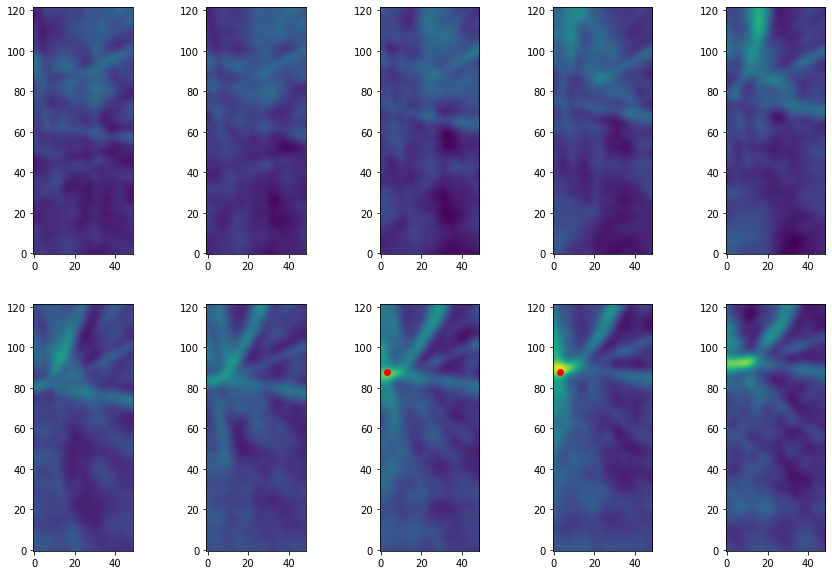

In [49]:
idx = 1

temp_srp = all_outputs[idx]['srp']
temp_srp = gaussian_filter(temp_srp, sigma = 2)

max_loc = np.unravel_index(np.argmax(temp_srp), temp_srp.shape)

fig, axs = plt.subplots(2,5, figsize = (15,10))
zs = np.linspace(0, temp_srp.shape[2]-1, 2*5).astype(int)
srp_min = np.amin(temp_srp)
srp_max = np.amax(temp_srp)
for i, ax in enumerate(axs.ravel()):
    ax.imshow(temp_srp[:, :, zs[i]], vmin=srp_min, vmax=srp_max, origin='lower')
    if np.abs(zs[i] - max_loc[2]) < 5:
        ax.scatter([max_loc[1]], [max_loc[0]], color = 'red')
plt.show()

In [166]:
xyz_grid = all_outputs[idx]['gridpts'].reshape(temp_srp.shape[0], temp_srp.shape[1], temp_srp.shape[2], -1)

In [167]:
maxx = xyz_grid.shape[0]
xp = xyz_grid[max(0,max_loc[0]-5):min(max_loc[0]+5, maxx), max_loc[1], max_loc[2]][:,0]
fp = temp_srp[max(0,max_loc[0]-5):min(max_loc[0]+5, maxx), max_loc[1], max_loc[2]]
xs = np.linspace(-0.1,0.1,200) + xyz_grid[max_loc[0], max_loc[1], max_loc[2]][0]
xs = xs[(xs >= np.min(xp)) & (xs <= np.max(xp))]

f = interp1d(xp, fp, kind='cubic')
ipx = f(xs)
ipx_max = np.argmax(ipx)

maxy = xyz_grid.shape[1]
yp = xyz_grid[max_loc[0], max(0,max_loc[1]-5):min(max_loc[1]+5, maxy), max_loc[2]][:,1]
fp = temp_srp[max_loc[0], max(0,max_loc[1]-5):min(max_loc[1]+5, maxy), max_loc[2]]
ys = np.linspace(-0.1,0.1,200) + xyz_grid[max_loc[0], max_loc[1], max_loc[2]][1]
ys = ys[(ys >= np.min(yp)+0.005) & (ys <= np.max(yp) - 0.005)]

f = interp1d(yp, fp, kind='cubic')
ipy = f(ys)
ipy_max = np.argmax(ipy)

In [168]:
fp = temp_srp[max(0,max_loc[0]-5):min(max_loc[0]+5, maxx), max(0,max_loc[1]-5):min(max_loc[1]+5, maxy), max_loc[2]]

In [169]:
print(xp, yp)
print(fp.shape)

[4.1  4.15 4.2  4.25 4.3  4.35 4.4  4.45 4.5  4.55] [-0.05  0.    0.05  0.1   0.15  0.2   0.25  0.3 ]
(10, 8)


In [177]:
xy = np.array(np.meshgrid(xs, ys)).T
xy_flat = xy.reshape(-1,2)
f = RectBivariateSpline(xp, yp, fp, s = 0)
fev = f.ev(xy_flat[:,0], xy_flat[:,1])
fev_max = np.argmax(fev)
themax_idx = np.unravel_index(fev_max, xy.shape[:2])
themax = xy_flat[fev_max,:]

[themax[0], themax[1], xyz_grid[max_loc[0], max_loc[1], max_loc[2]][2]]

[4.366582914572865, 0.09045226130653268, 2.1]

[4.366582914572865, 0.09045226130653268, 2.1]

In [175]:
[xs[ipx_max], ys[ipy_max], xyz_grid[max_loc[0], max_loc[1], max_loc[2]][2]]

[4.366582914572865, 0.09045226130653268, 2.1]

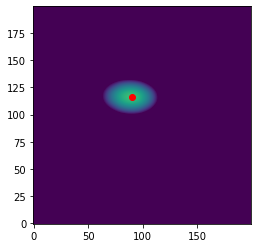

In [163]:
plt.imshow(fev.reshape(xy.shape[0], xy.shape[1]), vmin=29.25, vmax=29.27, origin='lower')
plt.scatter([themax_idx[1]],[themax_idx[0]], color='red')
plt.show()

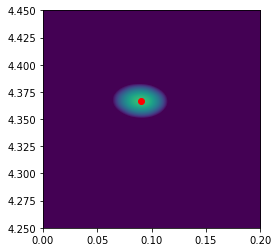

In [164]:
extent = [min(ys), max(ys), min(xs), max(xs)]
plt.imshow(fev.reshape(xy.shape[0], xy.shape[1]), vmin=29.25, vmax=29.27, extent=extent, origin='lower')
plt.scatter([themax[1]],[themax[0]], color='red')
plt.show()

In [43]:
xs = np.linspace(-0.1,0.1,200) + xyz_grid[max_loc[0], max_loc[1], max_loc[2]][0]
xp = xyz_grid[max_loc[0]-5:max_loc[0]+5, max_loc[1], max_loc[2]][:,0]
fp = temp_srp[max_loc[0]-5:max_loc[0]+5, max_loc[1], max_loc[2]]
xs = xs[(xs >= np.min(xp)) & (xs <= np.max(xp))]
f = interp1d(xp, fp, kind='cubic')
ipx = f(xs)

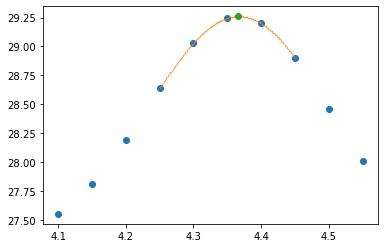

In [44]:
plt.scatter(xp, fp)
plt.scatter(xs, ipx, s=0.1)
ipx_max = np.argmax(ipx)
plt.scatter(xs[ipx_max], ipx[ipx_max])
#plt.xlim(2,2.2)
plt.show()

In [400]:
print(xp[np.argmax(fp)], xs[np.argmax(ipx)])

4.4 4.406532663316583


In [401]:
all_outputs[idx]['max_pt']

array([[4.3 , 0.15, 1.95]])

In [402]:
xyz_grid[max_loc[0], max_loc[1], max_loc[2]][1]

-0.05

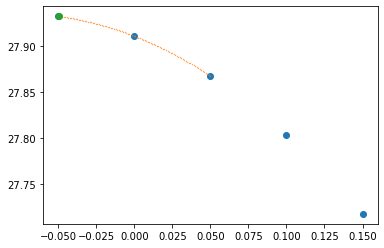

In [431]:
maxy = xyz_grid.shape[1]
yp = xyz_grid[max_loc[0], max(0,max_loc[1]-5):min(max_loc[1]+5, maxy), max_loc[2]][:,1]
fp = temp_srp[max_loc[0], max(0,max_loc[1]-5):min(max_loc[1]+5, maxy), max_loc[2]]
ys = np.linspace(-0.1,0.1,200) + xyz_grid[max_loc[0], max_loc[1], max_loc[2]][1]
ys = ys[(ys >= np.min(yp)) & (ys <= np.max(yp))]

f = interp1d(yp, fp, kind='cubic')
ipy = f(ys)

plt.scatter(yp, fp)
plt.scatter(ys, ipy, s=0.1)
ipy_max = np.argmax(ipy)
plt.scatter(ys[ipy_max], ipy[ipy_max])
# plt.xlim(2,2.2)
plt.show()

In [374]:
# NOW USE THIS!
[xs[ipx_max], ys[ipy_max], xyz_grid[max_loc[0], max_loc[1], max_loc[2]][2]]

[2.0954773869346734, 0.7874371859296483, 2.45]

In [368]:
max_loc

(43, 17, 50)

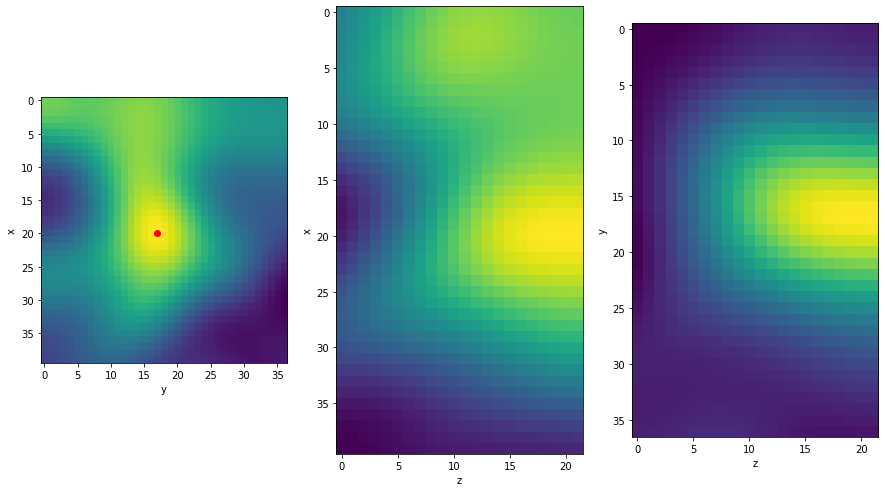

In [369]:
s = 20

max_loc = np.unravel_index(np.argmax(temp_srp), temp_srp.shape)

limits = np.zeros((3,3))
for i in range(3):
    limits[i,0] = max(0, max_loc[i] - s)
    limits[i,1]  = max_loc[i]
    limits[i,2] = min(temp_srp.shape[i], max_loc[i] + s)

limits = np.array(limits, dtype = int)
fig, axs = plt.subplots(1,3, figsize = (15,10))
axs[0].imshow(temp_srp[limits[0,0]:limits[0,2], limits[1,0]:limits[1,2], limits[2,1]])
axs[0].scatter([max_loc[1]-limits[1,0]], [max_loc[0]-limits[0,0]], color = 'red')
axs[0].set_xlabel("y")
axs[0].set_ylabel("x")
axs[1].imshow(temp_srp[limits[0,0]:limits[0,2], limits[1,1], limits[2,0]:limits[2,2]])
axs[1].set_xlabel("z")
axs[1].set_ylabel("x")
axs[2].imshow(temp_srp[limits[0,1], limits[1,0]:limits[1,2], limits[2,0]:limits[2,2]])
axs[2].set_xlabel("z")
axs[2].set_ylabel("y")
plt.show()

In [50]:
for out, rt in zip(all_outputs, singing_rostimes):
    singing_locations[rt]['max_pt'] = out['max_pt_updated']

In [51]:
srp_max = [out['max_pt_updated'] for out, rt in zip(all_outputs, singing_rostimes)]

In [52]:
norms = []
for _, sl in singing_locations.items():
    base_tip = sl['base_tips'][0]
    base_tip_norm = np.sqrt(np.sum((base_tip[0]-base_tip[1])**2))
    norms.append(base_tip_norm)
norms = np.array(norms)

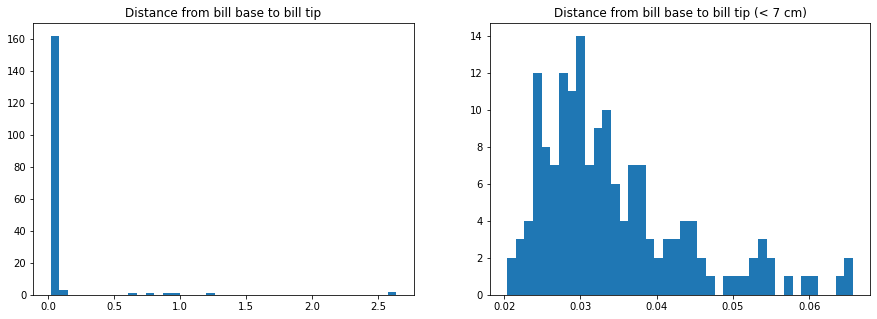

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.hist(norms, bins=40)
ax1.set_title("Distance from bill base to bill tip")
ax2.hist(norms[norms<0.07], bins=40)
ax2.set_title("Distance from bill base to bill tip (< 7 cm)")
plt.show()

In [223]:
len(norms)

172

In [148]:
len(norms[norms<0.07])

161

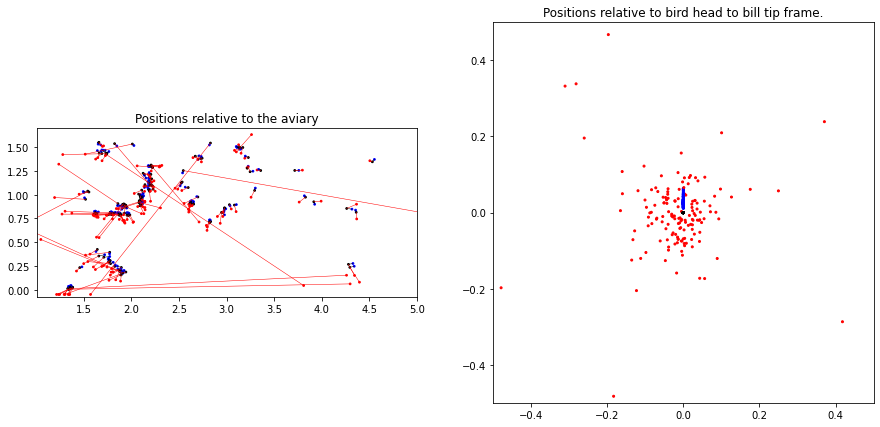

sigma: 1, 0.21713429851481802 pm 0.5080364116623699
sigma: 1, 0.07454156827640726 pm 0.04203764197699481


In [54]:
lab_offset = [0, 0]
#lab_offset = [0.002, 0.03] #[0.002, 0.036]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
bill_tips = []
bill_tips_lab = []
sound_locs = []
sound_locs_lab = []
for _, sl in singing_locations.items():
    point = sl['max_pt'][0].copy()
    point[0] = point[0] + lab_offset[0]
    point[1] = point[1] + lab_offset[1]
    base_tip = sl['base_tips'][0]
    base_tip_norm = np.sqrt(np.sum((base_tip[0]-base_tip[1])**2))
    bill_tips_lab.append(base_tip[1] - base_tip[0])
    sound_locs_lab.append(point - base_tip[0])
    if base_tip_norm > 0.07:
        continue
    xs = np.vstack([point, base_tip])[:,0]
    ys = np.vstack([point, base_tip])[:,1]
    ax1.scatter(xs, ys, c = ['red','black','blue'], s = 3)
    ax1.plot(xs[1:], ys[1:], color='black', linewidth = 0.5)
    ax1.plot(xs[:2], ys[:2], color='red', linewidth = 0.5)
    ax1.set_xlim(1.002, 5.003) #(-0.002, 6.003)
    ax1.set_ylim(-0.077, 1.7) #(-0.077, 2.376)
    ax1.set_aspect('equal', adjustable='box')
    ax1.set_title("Positions relative to the aviary")

    point_head = aviary_to_head_frame(point, base_tip)
    base_head = aviary_to_head_frame(base_tip[0], base_tip)
    tip_head = aviary_to_head_frame(base_tip[1], base_tip)
    bill_tips.append(tip_head)
    sound_locs.append(point_head)
    #print(point_head, base_head, tip_head)
    xs = np.vstack([point_head, base_head, tip_head])[:,0]
    ys = np.vstack([point_head, base_head, tip_head])[:,1]
    ax2.scatter(xs, ys, c = ['red','black','blue'], s = 4)
    ax2.set_xlim(-0.5, 0.5)
    ax2.set_ylim(-0.5, 0.5)
    ax2.set_aspect('equal', adjustable='box')
    ax2.set_title("Positions relative to bird head to bill tip frame.")

plt.show()

dist_to_sound = np.sqrt(np.sum(np.array(sound_locs)**2, axis = 1))
print(f"sigma: {sigma}, {np.mean(dist_to_sound)} pm {np.std(dist_to_sound)}")
print(f"sigma: {sigma}, {np.mean(dist_to_sound[dist_to_sound<0.2])} pm {np.std(dist_to_sound[dist_to_sound<0.2])}")

In [244]:
fig = ipv.figure()
bill_tips = []
bill_tips_lab = []
sound_locs = []
sound_locs_lab = []
for _, sl in singing_locations.items():

    point = sl['max_pt'][0]
    base_tip = sl['base_tips'][0]
    base_tip_norm = np.sqrt(np.sum((base_tip[0]-base_tip[1])**2))
    bill_tips_lab.append(base_tip[1] - base_tip[0])
    sound_locs_lab.append(point - base_tip[0])
    if base_tip_norm > 0.07:
        continue
    p3d = np.vstack([point, base_tip])
    ipv.scatter(p3d[:,0], p3d[:,1], p3d[:,2], size = 1, marker="sphere", color = np.array([[1,0,0],[0,0,1],[0,0,0]]))
    ipv.plot(p3d[1:,0], p3d[1:,1], p3d[1:,2], color=np.array([0,0,0]))
    ipv.plot(p3d[:2,0], p3d[:2,1], p3d[:2,2], color=np.array([1,0,0]))
    
    point_head = aviary_to_head_frame(point, base_tip, proj_z = False)
    base_head = aviary_to_head_frame(base_tip[0], base_tip, proj_z = False)
    tip_head = aviary_to_head_frame(base_tip[1], base_tip, proj_z = False)
    bill_tips.append(tip_head)
    sound_locs.append(point_head)
    
ipv.xlim(-0.002, 6.003)
ipv.ylim(-0.077, 2.376)
ipv.zlim(-0.022, 2.476)

ipv.squarelim()
ipv.show()

In [245]:
fig = ipv.figure()
for _, sl in singing_locations.items():

    point = sl['max_pt'][0]
    base_tip = sl['base_tips'][0]
    base_tip_norm = np.sqrt(np.sum((base_tip[0]-base_tip[1])**2))
    if base_tip_norm > 0.07:
        continue
    
    p3d = np.vstack([point, base_tip])

    point_head = aviary_to_head_frame(point, base_tip, proj_z = False)
    base_head = aviary_to_head_frame(base_tip[0], base_tip, proj_z = False)
    tip_head = aviary_to_head_frame(base_tip[1], base_tip, proj_z = False)
    
    if np.sqrt(np.sum(point_head**2)) > 0.20:
        continue
    
    p3d = np.vstack([point_head, base_head, tip_head])
    ipv.scatter(p3d[:,0], p3d[:,1], p3d[:,2], size = 1, marker="sphere", color = np.array([[1,0,0],[0,0,0],[0,0,1]]))
    #ipv.plot(p3d[[0,2],0], p3d[[0,2],1], p3d[[0,2],2], color=np.array([0,0,0]))

ipv.xlim(-0.2, 0.2)
ipv.ylim(-0.2, 0.2)
ipv.zlim(-0.2, 0.2)
ipv.squarelim()
ipv.show()

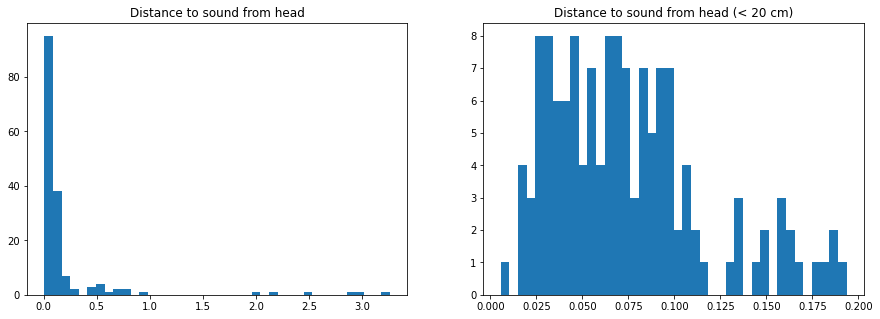

In [228]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.hist(dist_to_sound, bins=40)
ax1.set_title("Distance to sound from head")
ax2.hist(dist_to_sound[dist_to_sound<0.2], bins=40)
ax2.set_title("Distance to sound from head (< 20 cm)")
plt.show()

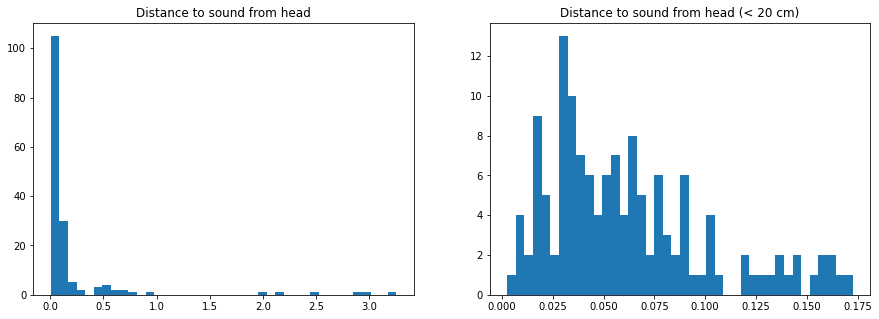

In [158]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.hist(dist_to_sound, bins=40)
ax1.set_title("Distance to sound from head")
ax2.hist(dist_to_sound[dist_to_sound<0.2], bins=40)
ax2.set_title("Distance to sound from head (< 20 cm)")
plt.show()

In [55]:
import matplotlib.cm as cm
from scipy.spatial import cKDTree

In [56]:
def data_coord2view_coord(p, resolution, pmin, pmax):
    dp = pmax - pmin
    dv = (p - pmin) / dp * resolution
    return dv

In [57]:
def kNN2DDens(xv, yv, resolution, neighbours, dim=2):
    """
    """
    # Create the tree
    tree = cKDTree(np.array([xv, yv]).T)
    # Find the closest nnmax-1 neighbors (first entry is the point itself)
    grid = np.mgrid[0:resolution, 0:resolution].T.reshape(resolution**2, dim)
    dists = tree.query(grid, neighbours)
    # Inverse of the sum of distances to each grid point.
    inv_sum_dists = 1. / dists[0].sum(1)

    # Reshape
    im = inv_sum_dists.reshape(resolution, resolution)
    return im

In [58]:
def index_to_coordinate(index, extent, origin):
    """Return the pixel center of an index."""
    left, right, bottom, top = extent

    hshift = 0.5 * np.sign(right - left)
    left, right = left + hshift, right - hshift
    vshift = 0.5 * np.sign(top - bottom)
    bottom, top = bottom + vshift, top - vshift

    if origin == 'upper':
        bottom, top = top, bottom

    return {
        "[0, 0]": (left, bottom),
        "[M', 0]": (left, top),
        "[0, N']": (right, bottom),
        "[M', N']": (right, top),
    }[index]

In [59]:
def density_plot(to_plot):
    if to_plot == "Head to bill tip in lab":
        data_to_plot = bill_tips_lab
        extent = [-0.07, 0.07, -0.07, 0.07]
    elif to_plot == "Head to sound location in lab":
        data_to_plot = sound_locs_lab
        extent = [-0.25, 0.25, -0.25, 0.25]
    else:
        data_to_plot = sound_locs
        extent = [-0.25, 0.25, -0.25, 0.25]

    xs = np.array(data_to_plot)[:,0]
    ys = np.array(data_to_plot)[:,1]

    resolution = 250

    # extent = [np.min(xs), np.max(xs), np.min(ys), np.max(ys)]

    xv = data_coord2view_coord(xs, resolution, extent[0], extent[1])
    yv = data_coord2view_coord(ys, resolution, extent[2], extent[3])

    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    for ax, neighbours in zip(axes.flatten(), [0, 16, 32, 63]):

        if neighbours == 0:
            ax.plot(xs, ys, 'k.', markersize=5, color = [0,0,0,0.3])
            ax.scatter([0],[0], s=10, color='red')
            ax.set_aspect('equal')
            ax.set_title(to_plot)
            ax.set_xlim(extent[0], extent[1])
            ax.set_ylim(extent[2], extent[3])
        else:

            im = kNN2DDens(xv, yv, resolution, neighbours)
            
            lower_left = index_to_coordinate("[0, 0]", extent, 'lower')
            upper_right = index_to_coordinate("[M', N']", extent, 'lower')
            
            peak = np.array(np.unravel_index(np.argmax(im), im.shape))
            #peak[0] = im.shape[0] - peak[0]
            peak = (peak - im.shape[0]/2)/im.shape[0]*(lower_left[0] - upper_right[0])
            
            print(peak)
            
            ax.imshow(im, origin='lower', extent=extent, cmap=cm.Blues)
            #ax.imshow(im, cmap=cm.Blues)
            ax.scatter([0],[0], s=10, color='black')
            ax.scatter([peak[1]], [peak[0]], s = 10, color='red')
            ax.set_title("Smoothing over %d neighbours" % neighbours)
            ax.set_xlim(extent[0], extent[1])
            ax.set_ylim(extent[2], extent[3])

    plt.show()
    # plt.savefig('new.png', dpi=150, bbox_inches='tight')

[ 0.12728 -0.06536]
[0.13416 0.00344]
[ 0.12728 -0.02064]


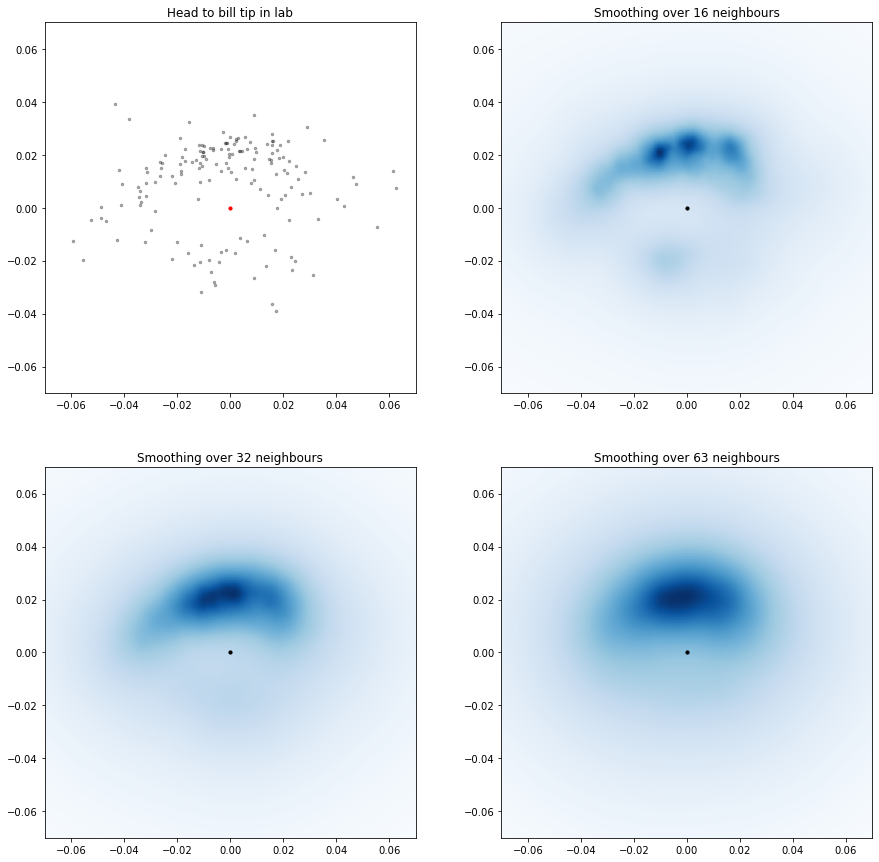

[-0.032  0.016]
[-0.03   0.014]
[-0.036 -0.002]


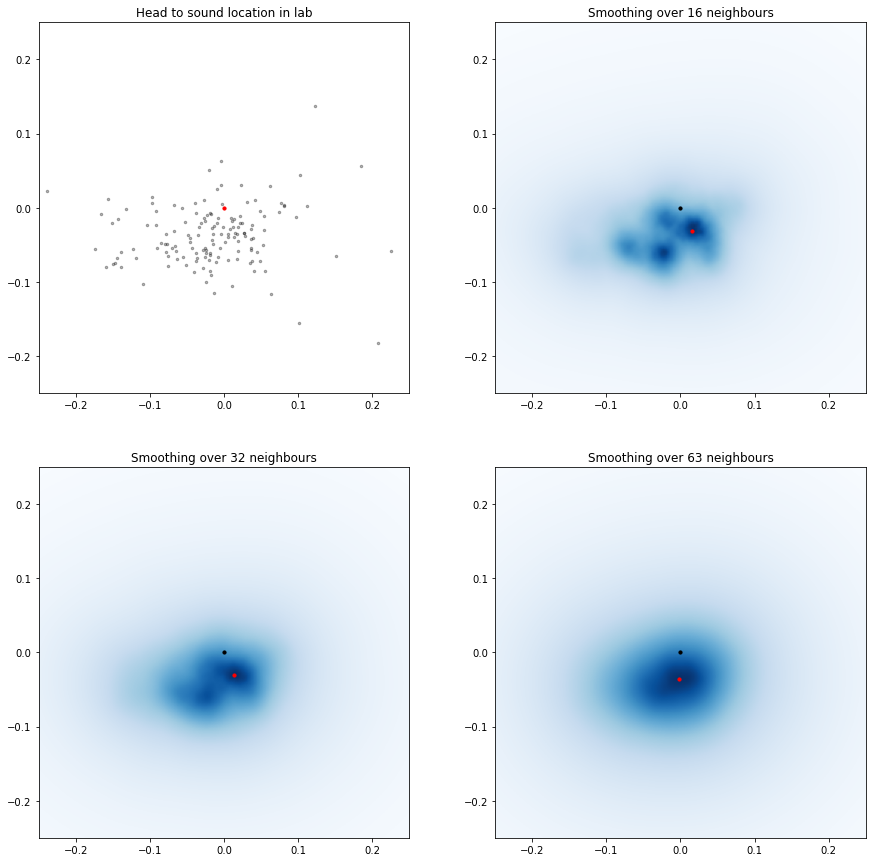

[-0.016 -0.012]
[-0.02  -0.004]
[-0.032  0.   ]


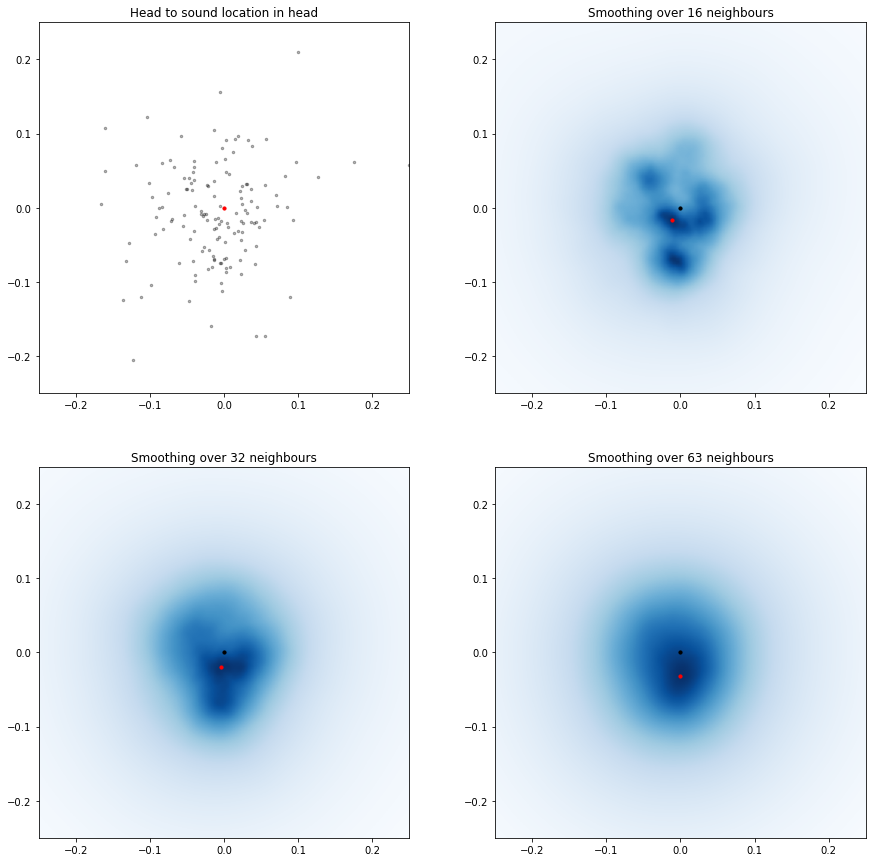

In [60]:
density_plot("Head to bill tip in lab")
density_plot("Head to sound location in lab")
density_plot("Head to sound location in head")

[ 0.12728 -0.06536]
[0.13416 0.00344]
[ 0.12728 -0.02064]


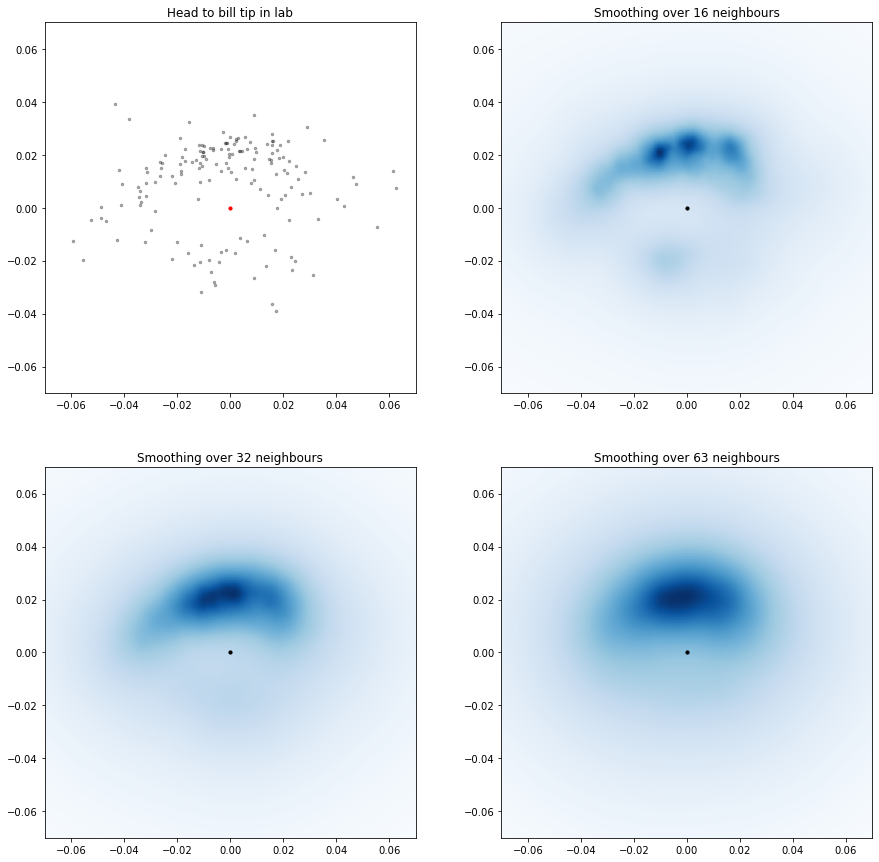

[-0.032  0.016]
[-0.03   0.014]
[-0.036 -0.002]


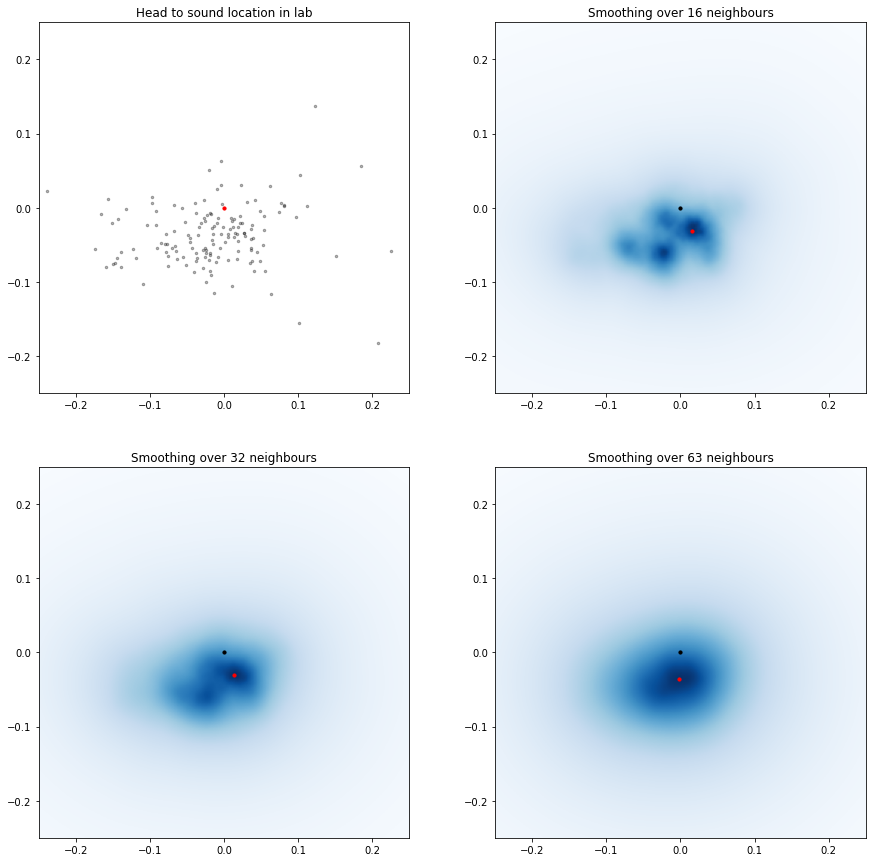

[-0.016 -0.012]
[-0.02  -0.004]
[-0.032  0.   ]


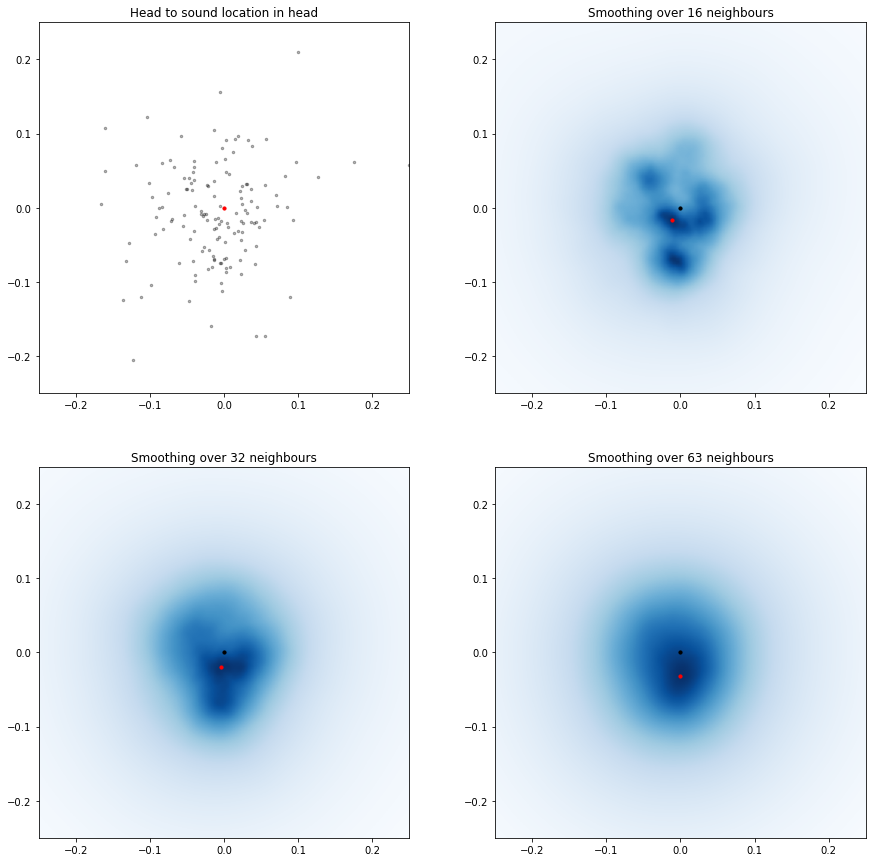

In [184]:
density_plot("Head to bill tip in lab")
density_plot("Head to sound location in lab")
density_plot("Head to sound location in head")

In [61]:
singing_locs = [[idx, i[0], xyz] for idx, (i, xyz) in enumerate(zip(singing_points_info, singing_points_3d)) if 'bird_head' in i[2]]
nonsinging_locs = [[idx, i[0], xyz] for idx, (i, xyz) in enumerate(zip(nonsinging_points_info, nonsinging_points_3d)) if 'bird_head' in i[2]]

In [62]:
singing_rostimes = [sl[1] for sl in singing_locs]

In [63]:
nearest = []
for sr in singing_rostimes:
    sl = np.array([s[2] for s in singing_locs if s[1] == sr])
    nsl = np.array([s[2] for s in nonsinging_locs if s[1] == sr])
    if nsl.size > 0:
        dists = np.sqrt(np.sum((nsl[:,:2] - sl[:,:2])**2, axis = 1))
        nearest.append(min(dists))
dist_to_nearest = np.array(nearest)

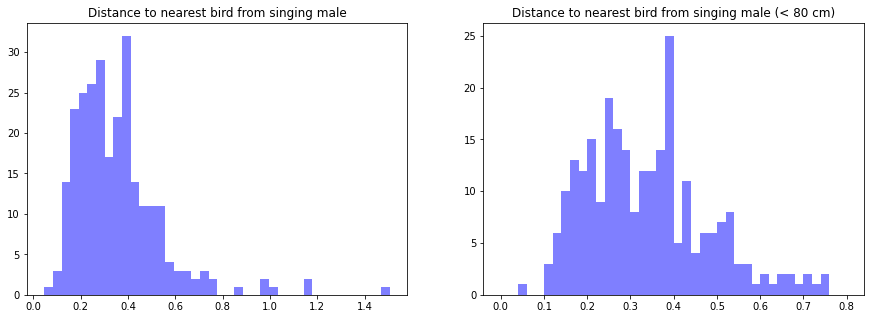

In [208]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.hist(dist_to_nearest, bins=40, fc=(0, 0, 1, 0.5))
ax1.set_title("Distance to nearest bird from singing male")

ax2.hist(dist_to_nearest[dist_to_nearest<0.8], bins=40, range=(0,0.8), fc=(0, 0, 1, 0.5))
#ax2.hist(dist_to_sound[dist_to_sound<0.8], bins=40, range=(0,0.8), fc=(1, 0, 0, 0.5))
ax2.set_title("Distance to nearest bird from singing male (< 80 cm)")
plt.show()

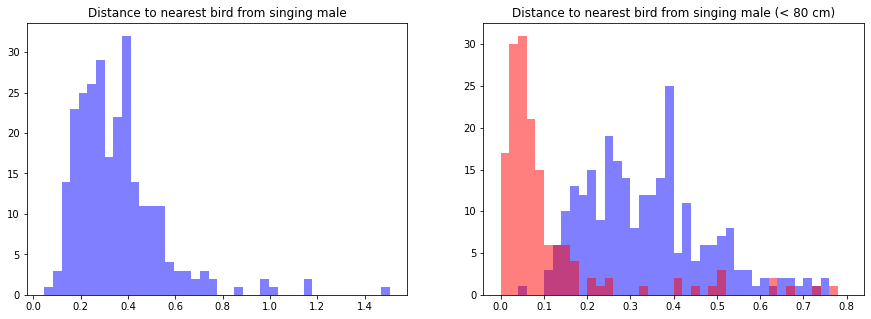

In [203]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.hist(dist_to_nearest, bins=40, fc=(0, 0, 1, 0.5))
ax1.set_title("Distance to nearest bird from singing male")

ax2.hist(dist_to_nearest[dist_to_nearest<0.8], bins=40, range=(0,0.8), fc=(0, 0, 1, 0.5))
ax2.hist(dist_to_sound[dist_to_sound<0.8], bins=40, range=(0,0.8), fc=(1, 0, 0, 0.5))
ax2.set_title("Distance to nearest bird from singing male (< 80 cm)")
plt.show()

In [64]:
def calculate_pr(singing_locs, nonsinging_locs, singing_rostimes, distance_threshold, offset = None):
    correct = 0
    incorrect = 0
    for sr in singing_locations.keys():
        
        sbird_l = np.array([s[2] for s in singing_locs if s[1] == sr])[0]
        nsbird_l = np.array([s[2] for s in nonsinging_locs if s[1] == sr])
        sound_l = singing_locations[sr]['max_pt'][0].copy()
        if offset is not None:
            sound_l[0] = sound_l[0] + offset[0]
            sound_l[1] = sound_l[1] + offset[1]
        
        if nsbird_l.size == 0:
            continue
        
        dist_sbird = np.sqrt(np.sum((sbird_l - sound_l)**2))
        dist_nsbird = min(np.sqrt(np.sum((nsbird_l - sound_l)**2, axis = 1)))
        
        if dist_nsbird < dist_sbird and dist_nsbird < distance_threshold:
            incorrect += 1
        elif dist_sbird < dist_nsbird and dist_sbird < distance_threshold:
            correct += 1
    
    if correct + incorrect > 0:
            
        precision = correct/(correct + incorrect)
        recall = correct/len(singing_locations)
        
    else:
        
        precision = np.nan
        recall = 0
    
    return precision, recall
    

In [65]:
# Make PR curves
distance_thresholds = np.linspace(0,0.5,401)
data = []
data_adj = []
maxp = np.nan
for d in distance_thresholds:
    p, r = calculate_pr(singing_locs, nonsinging_locs, singing_rostimes, d)
    data.append([d, p, r])
    
    p, r = calculate_pr(singing_locs, nonsinging_locs, singing_rostimes, d, offset = [0.002, 0.03]) # offset =[0.012, 0.052])
    data_adj.append([d, p, r])
    
data = np.array(data)
data_adj = np.array(data_adj)

In [82]:
np.argmin(np.abs(data_adj[:,0] - 0.1))

80

In [84]:
data_adj[80]

array([0.1       , 0.99090909, 0.63372093])

In [280]:
print(f"Average precision: {np.nanmean(data_adj[:,1])}")

Average precision: 0.9412188420342162


In [221]:
print(f"Average precision: {np.nanmean(data_adj[:,1])}")

Average precision: 0.9412188420342162


In [176]:
print(f"Average precision: {np.nanmean(data_adj[:,1])}")

Average precision: 0.9233289886630218


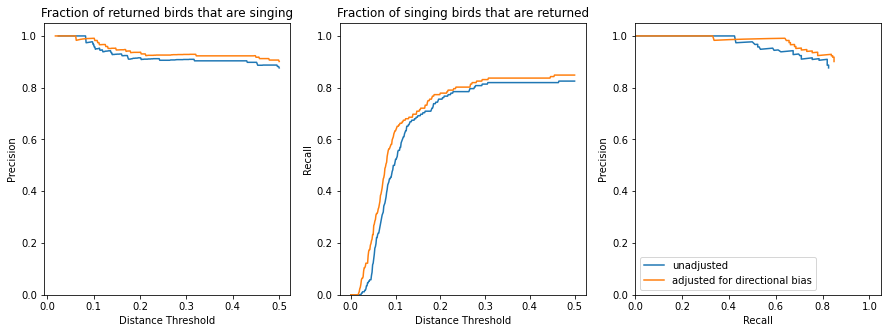

In [222]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].plot(data[:,0], data[:,1])
axs[0].plot(data_adj[:,0], data_adj[:,1])
axs[0].set_ylim(0,1.05)
axs[0].set_xlabel("Distance Threshold")
axs[0].set_ylabel("Precision")
axs[0].set_title("Fraction of returned birds that are singing")
axs[1].plot(data[:,0], data[:,2])
axs[1].plot(data_adj[:,0], data_adj[:,2])
axs[1].set_ylim(0,1.05)
axs[1].set_title("Fraction of singing birds that are returned")
axs[1].set_xlabel("Distance Threshold")
axs[1].set_ylabel("Recall")
line0, = axs[2].plot(data[:,2], data[:,1], label='unadjusted')
line1, = axs[2].plot(data_adj[:,2], data_adj[:,1], label='adjusted for directional bias')
axs[2].set_ylim(0,1.05)
axs[2].set_xlim(0,1.05)
axs[2].set_xlabel("Recall")
axs[2].set_ylabel("Precision")

axs[2].legend(handles=[line0, line1])

plt.show()

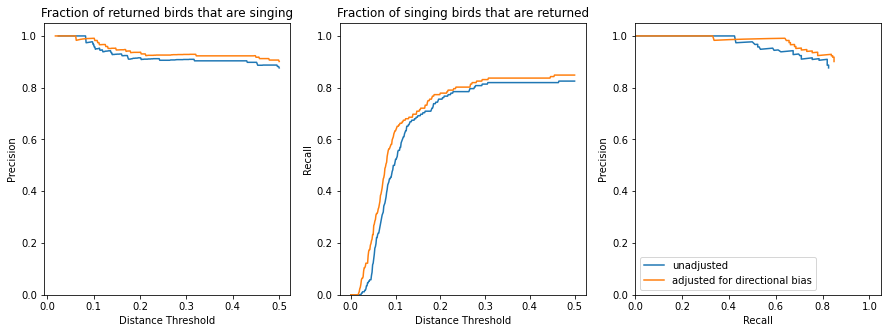

In [281]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].plot(data[:,0], data[:,1])
axs[0].plot(data_adj[:,0], data_adj[:,1])
axs[0].set_ylim(0,1.05)
axs[0].set_xlabel("Distance Threshold")
axs[0].set_ylabel("Precision")
axs[0].set_title("Fraction of returned birds that are singing")
axs[1].plot(data[:,0], data[:,2])
axs[1].plot(data_adj[:,0], data_adj[:,2])
axs[1].set_ylim(0,1.05)
axs[1].set_title("Fraction of singing birds that are returned")
axs[1].set_xlabel("Distance Threshold")
axs[1].set_ylabel("Recall")
line0, = axs[2].plot(data[:,2], data[:,1], label='unadjusted')
line1, = axs[2].plot(data_adj[:,2], data_adj[:,1], label='adjusted for directional bias')
axs[2].set_ylim(0,1.05)
axs[2].set_xlim(0,1.05)
axs[2].set_xlabel("Recall")
axs[2].set_ylabel("Precision")

axs[2].legend(handles=[line0, line1])

plt.show()

In [59]:
def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple                                                        
    xo = float(xo)                                                              
    yo = float(yo)                                                              
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)   
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)    
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)   
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)         
                        + c*((y-yo)**2)))                                   
    return g.ravel()

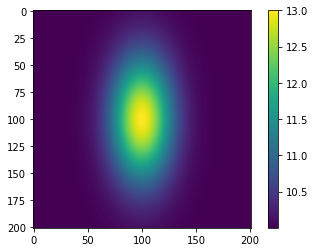

In [78]:
# Create x and y indices
x = np.linspace(0, 200, 201)
y = np.linspace(0, 200, 201)
x, y = np.meshgrid(x, y)

#create data
data = twoD_Gaussian((x, y), 3, 100, 100, 20, 40, 0, 10)

# plot twoD_Gaussian data generated above
plt.figure()
plt.imshow(data.reshape(201, 201))
plt.colorbar()

In [50]:
# add some noise to the data and try to fit the data generated beforehand
initial_guess = (3,100,100,20,40,0,10)

data_noisy = data + 0.2*np.random.normal(size=data.shape)

popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), data_noisy, p0=initial_guess)

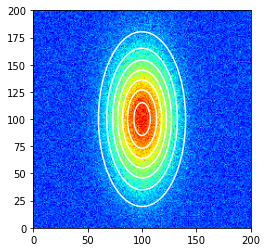

In [53]:
data_fitted = twoD_Gaussian((x, y), *popt)

fig, ax = plt.subplots(1, 1)
ax.imshow(data_noisy.reshape(201, 201), cmap=plt.cm.jet, origin='lower',
    extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted.reshape(201, 201), 8, colors='w')
plt.show()

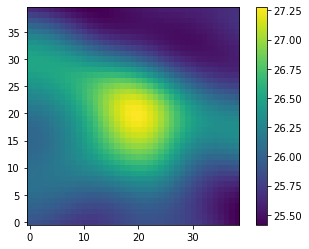

In [91]:
s = 20

max_loc = np.unravel_index(np.argmax(temp_srp), temp_srp.shape)

limits = np.zeros((3,3))
for i in range(3):
    limits[i,0] = max(0, max_loc[i] - s)
    limits[i,1]  = max_loc[i]
    limits[i,2] = min(temp_srp.shape[i], max_loc[i] + s)
limits = limits.astype(int)

crop_srp = temp_srp[limits[0,0]:limits[0,2], limits[1,0]:limits[1,2], limits[2,1]]
values = crop_srp.flatten()

grid_x, grid_y = np.meshgrid(range(0, crop_srp.shape[1]), range(0, crop_srp.shape[0]))

# plot twoD_Gaussian data generated above
plt.imshow(values.reshape(crop_srp.shape[0], crop_srp.shape[1]), origin='lower')
plt.colorbar()

In [99]:
vmax = np.amax(values)
vmin = np.amin(values)
initial_guess = (vmax-vmin,crop_srp.shape[0]//2,crop_srp.shape[1]//2,15,15,0,vmin)
popt, pcov = opt.curve_fit(twoD_Gaussian, (grid_x, grid_y), values, p0=initial_guess)
data_fitted = twoD_Gaussian((grid_x, grid_y), *popt)

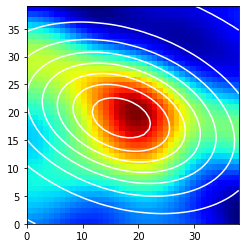

In [100]:
fig, ax = plt.subplots(1, 1)
ax.imshow(values.reshape(crop_srp.shape[0], crop_srp.shape[1]), cmap=plt.cm.jet, origin='lower',
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()))
ax.contour(grid_x, grid_y, data_fitted.reshape(crop_srp.shape[0], crop_srp.shape[1]), 8, colors='w')
plt.show()

In [ ]:
# interp_srp = griddata(points, values, (grid_x, grid_y, grid_z), method='linear')

In [ ]:
# print(interp_srp.shape)

# fig, axs = plt.subplots(1,3, figsize = (15,10))
# axs[0].imshow(interp_srp[:,:,interp_srp.shape[2]//2])
# axs[0].set_xlabel("y")
# axs[0].set_ylabel("x")
# axs[1].imshow(interp_srp[:,interp_srp.shape[1]//2,:])
# axs[1].set_xlabel("z")
# axs[1].set_ylabel("x")
# axs[2].imshow(interp_srp[interp_srp.shape[0]//2,:,:])
# axs[2].set_xlabel("z")
# axs[2].set_ylabel("y")
# plt.show()

Frame([[[25.55036585, 25.54167895, 25.52601941, ..., 25.51631229,
         25.52475366, 25.5295136 ],
        [25.55618842, 25.5471002 , 25.53069121, ..., 25.50970198,
         25.51750805, 25.52192542],
        [25.56785897, 25.55797762, 25.54008692, ..., 25.49711544,
         25.50377353, 25.50757111],
        ...,
        [24.94925038, 24.94885223, 24.9481579 , ..., 25.30312986,
         25.33914475, 25.35810779],
        [24.94760364, 24.94728739, 24.94673862, ..., 25.29591146,
         25.33228863, 25.35145205],
        [24.94670896, 24.94643438, 24.94595925, ..., 25.29223701,
         25.32881371, 25.34808736]],

       [[25.55882982, 25.550168  , 25.53451135, ..., 25.50565486,
         25.51330279, 25.51765371],
        [25.56427642, 25.55523444, 25.53886771, ..., 25.49924217,
         25.50627833, 25.51029844],
        [25.57523714, 25.56544184, 25.54766748, ..., 25.48704283,
         25.49297306, 25.49639435],
        ...,
        [24.95170837, 24.95123266, 24.95039769, ..., 25.29406798,
         25.3292488 , 25.34777455],
        [24.94995456, 24.9495588 , 24.94886594, ..., 25.28721568,
         25.32274828, 25.34146759],
        [24.94899933, 24.9486445 , 24.94802402, ..., 25.28373724,
         25.31946492, 25.33829143]],

       [[25.57478859, 25.5662087 , 25.55062138, ..., 25.48520338,
         25.49127983, 25.49482159],
        [25.57952097, 25.57059925, 25.5543733 , ..., 25.47914924,
         25.48465741, 25.48789008],
        [25.58913569, 25.57953267, 25.56203346, ..., 25.46765283,
         25.47213286, 25.47480544],
        ...,
        [24.95685911, 24.95621145, 24.95506183, ..., 25.27744759,
         25.31101527, 25.32869366],
        [24.95490764, 24.95433544, 24.95331994, ..., 25.27129947,
         25.30520118, 25.32306128],
        [24.95384037, 24.95330733, 24.95236107, ..., 25.26819685,
         25.30228623, 25.32024834]],

       ...,

       [[25.42452751, 25.43323621, 25.44881625, ..., 25.99514769,
         25.99736386, 25.99813349],
        [25.42048682, 25.4292725 , 25.4450254 , ..., 25.98695412,
         25.98853679, 25.98900374],
        [25.41376531, 25.42266835, 25.43869544, ..., 25.97161867,
         25.97206408, 25.97199123],
        ...,
        [24.57591848, 24.58159312, 24.59227837, ..., 24.92690942,
         24.91753753, 24.91244048],
        [24.57150966, 24.57747359, 24.58871244, ..., 24.93334276,
         24.9238459 , 24.91867262],
        [24.56924973, 24.57537691, 24.58692692, ..., 24.93682322,
         24.92726346, 24.92205114]],

       [[25.41059005, 25.42038572, 25.43794854, ..., 25.98163398,
         25.98125368, 25.98065195],
        [25.40644469, 25.41630426, 25.43401629, ..., 25.97328876,
         25.97227767, 25.97137651],
        [25.39960445, 25.4095562 , 25.42749678, ..., 25.95775072,
         25.95561428, 25.95418281],
        ...,
        [24.56102318, 24.56637898, 24.57646889, ..., 24.89396362,
         24.88470157, 24.87965836],
        [24.55508787, 24.56075827, 24.57145135, ..., 24.89939803,
         24.88999117, 24.8848618 ],
        [24.55203709, 24.55788505, 24.56891717, ..., 24.90237878,
         24.89289776, 24.88772371]],

       [[25.40282536, 25.41319014, 25.43179198, ..., 25.97388176,
         25.97211428, 25.97078122],
        [25.39865621, 25.40907769, 25.4278156 , ..., 25.96549355,
         25.96310032, 25.96147138],
        [25.39181393, 25.40231382, 25.42125509, ..., 25.94991939,
         25.94641384, 25.94426306],
        ...,
        [24.55405074, 24.55924425, 24.5690309 , ..., 24.87755394,
         24.86837078, 24.86336707],
        [24.54732103, 24.5528423 , 24.56325778, ..., 24.88243135,
         24.87309339, 24.86799856],
        [24.54385882, 24.54956507, 24.56033402, ..., 24.88513268,
         24.87571492, 24.87057258]]])
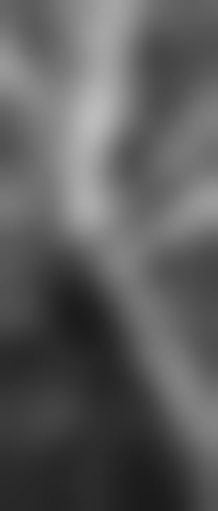
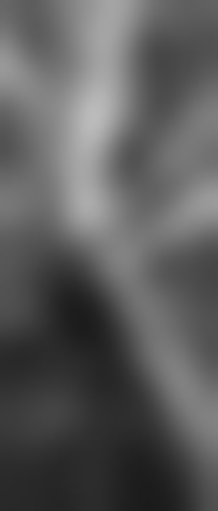
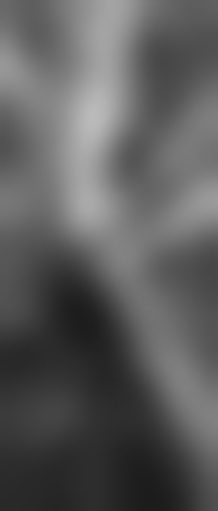
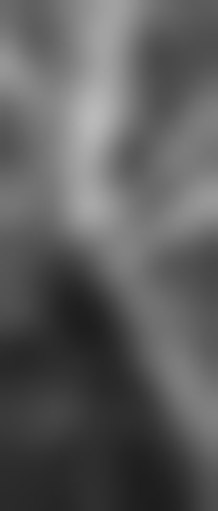
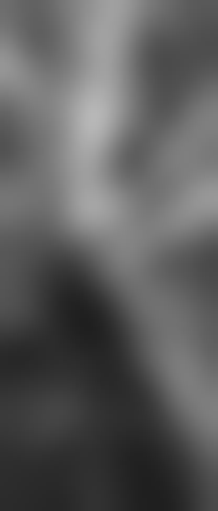
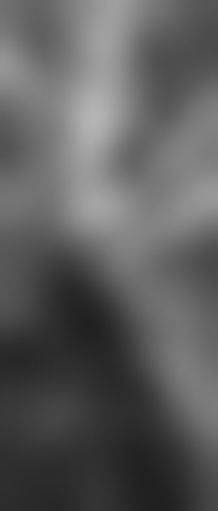
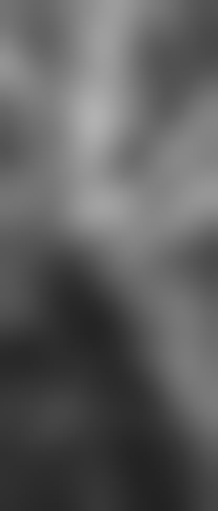
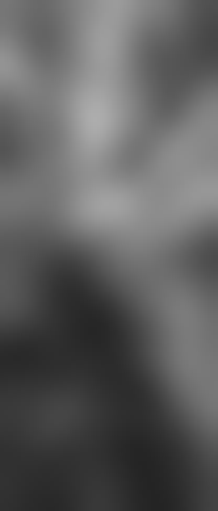
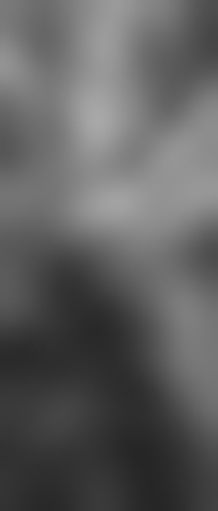
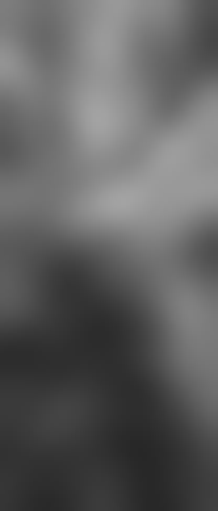
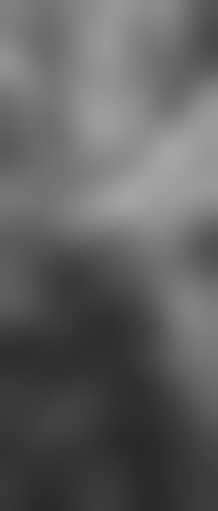
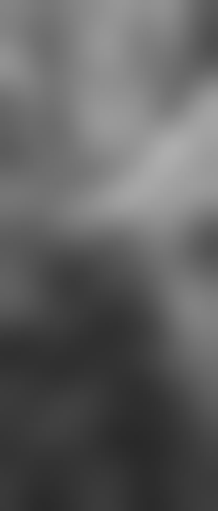
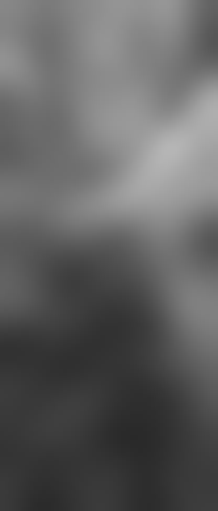
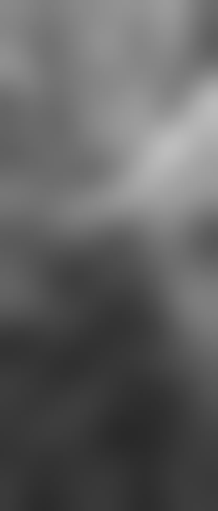
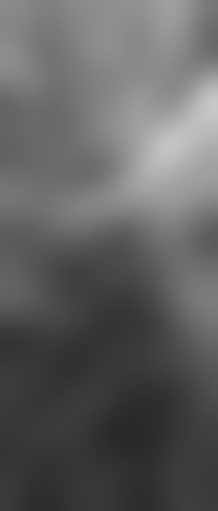
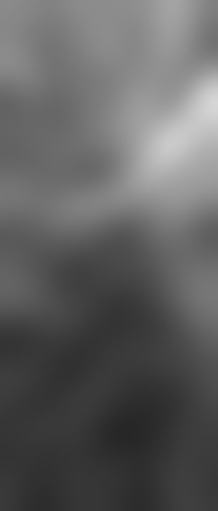
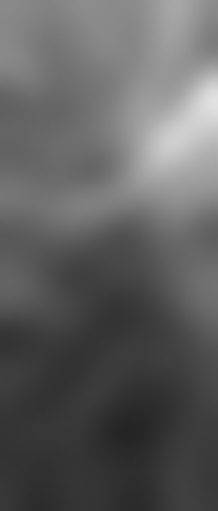
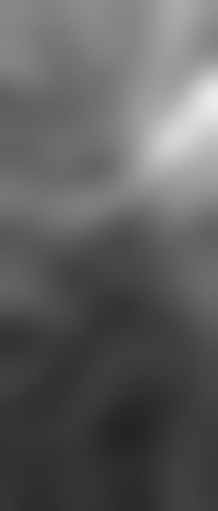
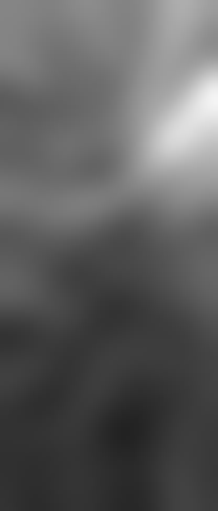
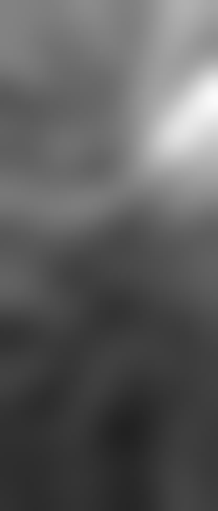
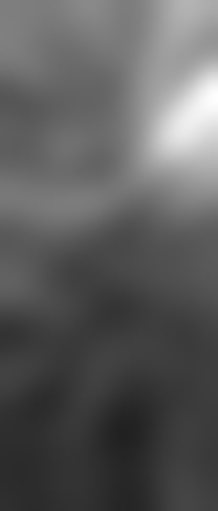
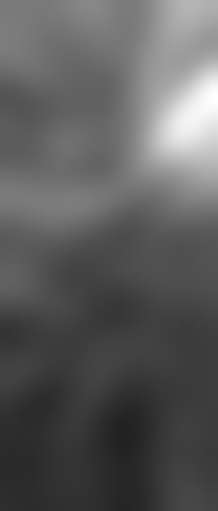
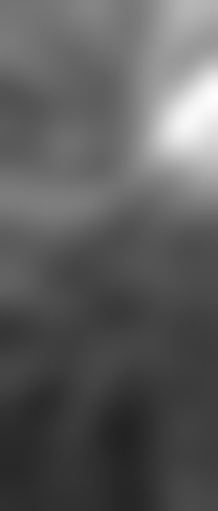
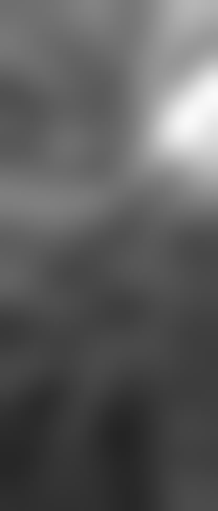
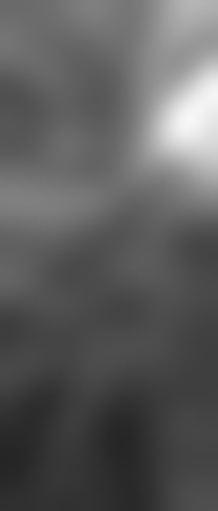
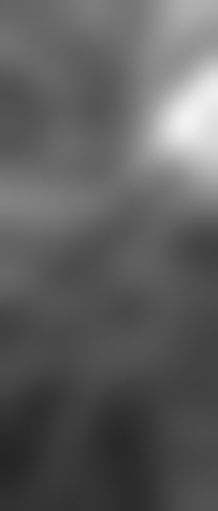
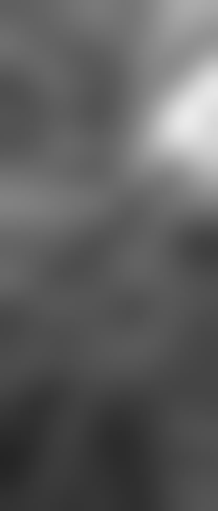
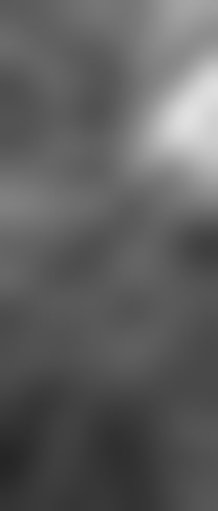
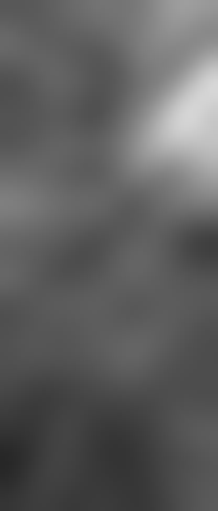
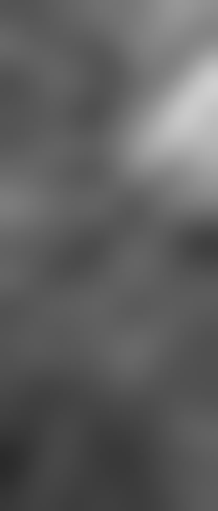
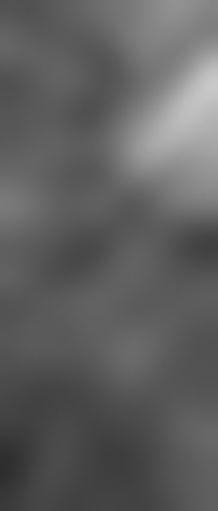
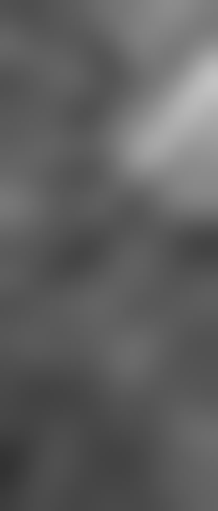
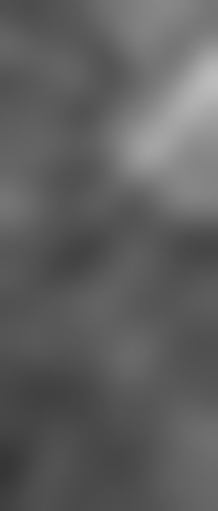
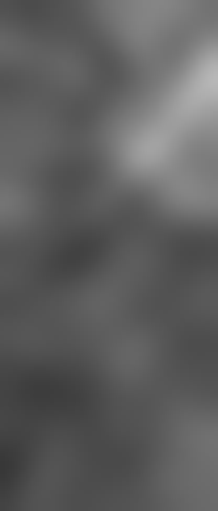
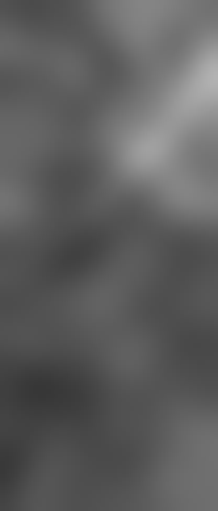
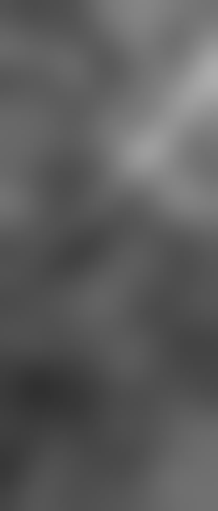
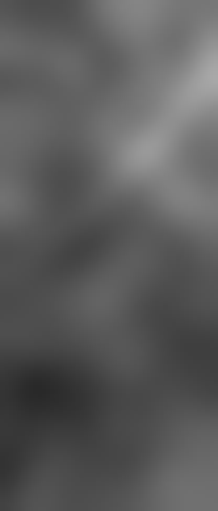
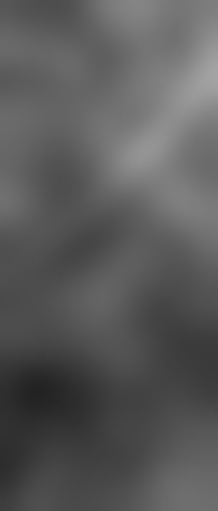
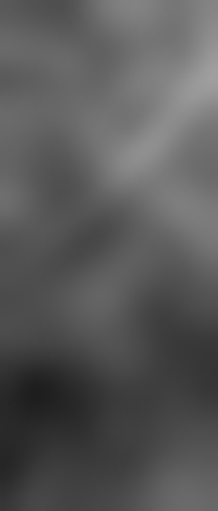
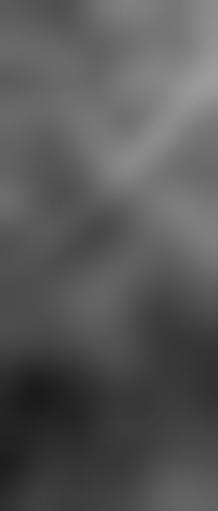
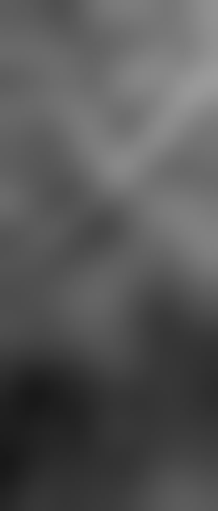
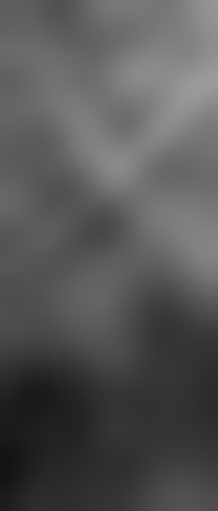
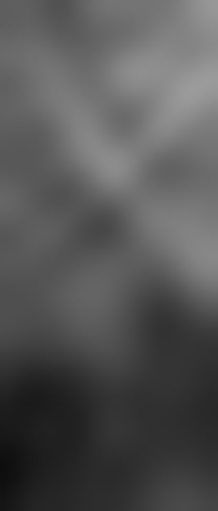
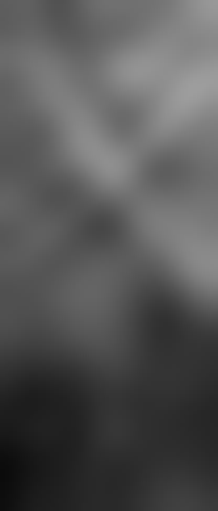
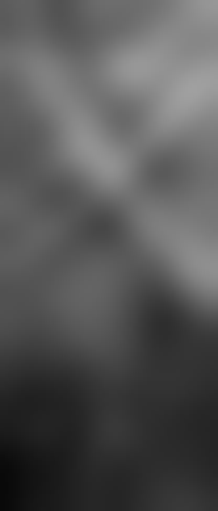
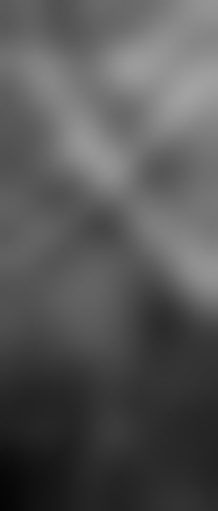
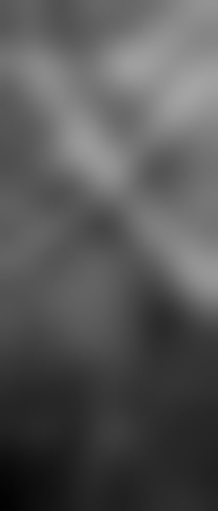
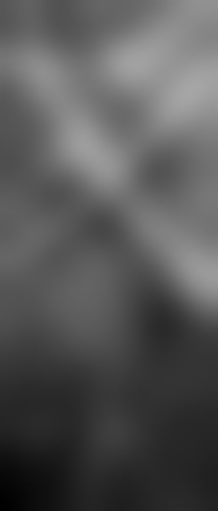
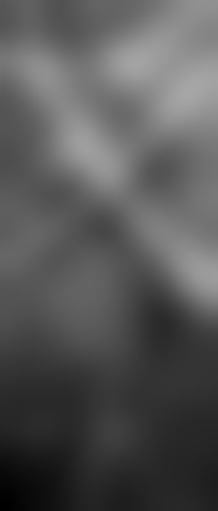

In [209]:
frames = pims.Frame(temp_srp.swapaxes(0,1))
frames.bundle_axes = 'xy'
frames.iter_axes = 't'
frames

Features found: 2


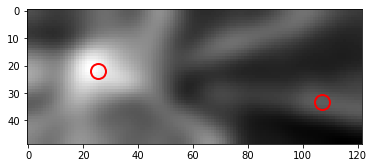

<AxesSubplot:>

In [210]:
features3 = tp.locate(frames[:,:,max_loc[2]], diameter=(31, 31))
print('Features found: {0}'.format(len(features3)))
tp.annotate(features3, frames[:,:,max_loc[2]])

In [211]:
features3

,y,x,mass,size,ecc,signal,raw_mass,ep
0,21.984388,25.251114,183.308180,7.926003,0.175676,0.833071,18697.821395,0.018393
1,33.256081,106.994165,76.149178,7.928847,0.484221,0.401834,17935.127893,-0.123151


In [213]:
int(features3['y'][0].item())

21

In [167]:
ravel_idx = 22254
print(all_outputs[idx]['gridpts'][ravel_idx])
print(np.unravel_index(ravel_idx, temp_srp.shape))
print(all_outputs[idx]['gridpts'].reshape(temp_srp.shape[0], temp_srp.shape[1], temp_srp.shape[2], -1)[np.unravel_index(ravel_idx, temp_srp.shape)])

[0.35 1.7  2.45]
(8, 35, 50)
[0.35 1.7  2.45]
